# Comprehensive Options Pricing Program

### Import Libraries / Packages

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from functools import partial
import pandas as pd
from matplotlib.gridspec import GridSpec
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

### Black-Scholes-Merton Functions

In [2]:
def d1(S, K, r, sigma, T):
    """Calculate d1 parameter for BSM"""
    return (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))

In [3]:
def d2(S, K, r, sigma, T):
    """Calculate d2 parameter for BSM"""
    return d1(S, K, r, sigma, T) - sigma * np.sqrt(T)

In [4]:
def bsm_call_price(S, K, r, sigma, T):
    """Calculate BSM call option price"""
    if T <= 0:
        return max(0, S - K)
    return S * norm.cdf(d1(S, K, r, sigma, T)) - K * np.exp(-r * T) * norm.cdf(d2(S, K, r, sigma, T))

In [6]:
def bsm_put_price(S, K, r, sigma, T):
    """Calculate BSM put option price"""
    if T <= 0:
        return max(0, K - S)
    return K * np.exp(-r * T) * norm.cdf(-d2(S, K, r, sigma, T)) - S * norm.cdf(-d1(S, K, r, sigma, T))

### The Greeks

In [7]:
def delta_call(S, K, r, sigma, T):
    """Calculate delta for call option"""
    if T <= 0:
        return 1.0 if S > K else 0.0
    return norm.cdf(d1(S, K, r, sigma, T))

In [36]:
def delta_put(S, K, r, sigma, T):
    """Calculate delta for put option"""
    if T <= 0:
        return -1.0 if S < K else 0.0
    return norm.cdf(d1(S, K, r, sigma, T)) - 1

In [9]:
def gamma(S, K, r, sigma, T):
    """Calculate gamma (same for calls and puts)"""
    if T <= 0:
        return 0.0
    return norm.pdf(d1(S, K, r, sigma, T)) / (S * sigma * np.sqrt(T))

In [10]:
def theta_call(S, K, r, sigma, T):
    """Calculate theta for call option"""
    if T <= 0:
        return 0.0
    term1 = -S * norm.pdf(d1(S, K, r, sigma, T)) * sigma / (2 * np.sqrt(T))
    term2 = -r * K * np.exp(-r * T) * norm.cdf(d2(S, K, r, sigma, T))
    return (term1 + term2) / 365

In [11]:
def theta_put(S, K, r, sigma, T):
    """Calculate theta for put option"""
    if T <= 0:
        return 0.0
    term1 = -S * norm.pdf(d1(S, K, r, sigma, T)) * sigma / (2 * np.sqrt(T))
    term2 = r * K * np.exp(-r * T) * norm.cdf(-d2(S, K, r, sigma, T))
    return (term1 + term2) / 365

In [12]:
def vega(S, K, r, sigma, T):
    """Calculate vega (same for calls and puts)"""
    if T <= 0:
        return 0.0
    return S * np.sqrt(T) * norm.pdf(d1(S, K, r, sigma, T)) / 100

In [13]:
def rho_call(S, K, r, sigma, T):
    """Calculate rho for call option"""
    if T <= 0:
        return 0.0
    return K * T * np.exp(-r * T) * norm.cdf(d2(S, K, r, sigma, T)) / 100

In [14]:
def rho_put(S, K, r, sigma, T):
    """Calculate rho for put option"""
    if T <= 0:
        return 0.0
    return -K * T * np.exp(-r * T) * norm.cdf(-d2(S, K, r, sigma, T)) / 100

### Binomial Tree Model for American Options

In [15]:
def binomial_tree_option(S, K, r, sigma, T, steps, option_type='call', exercise='european'):
    """Price an option using the binomial tree model
    
    Parameters:
    S: Initial stock price
    K: Strike price
    r: Risk-free rate (annualized)
    sigma: Volatility (annualized)
    T: Time to expiration (in years)
    steps: Number of time steps in the tree
    option_type: 'call' or 'put'
    exercise: 'european' or 'american'
    
    Returns:
    option_price: Price of the option
    """
    dt = T / steps
    u = np.exp(sigma * np.sqrt(dt))
    d = 1 / u
    p = (np.exp(r * dt) - d) / (u - d)
    
    # Initialize stock price tree
    stock_tree = np.zeros((steps + 1, steps + 1))
    for i in range(steps + 1):
        for j in range(i + 1):
            stock_tree[j, i] = S * (u ** (i - j)) * (d ** j)
    
    # Initialize option value tree
    option_tree = np.zeros((steps + 1, steps + 1))
    
    # Compute option values at expiration
    if option_type.lower() == 'call':
        option_tree[:, steps] = np.maximum(0, stock_tree[:, steps] - K)
    else:
        option_tree[:, steps] = np.maximum(0, K - stock_tree[:, steps])
    
    # Backward induction for earlier times
    for i in range(steps - 1, -1, -1):
        for j in range(i + 1):
            option_tree[j, i] = np.exp(-r * dt) * (p * option_tree[j, i + 1] + (1 - p) * option_tree[j + 1, i + 1])
            
            # Check for early exercise if American
            if exercise.lower() == 'american':
                if option_type.lower() == 'call':
                    option_tree[j, i] = max(option_tree[j, i], stock_tree[j, i] - K)
                else:
                    option_tree[j, i] = max(option_tree[j, i], K - stock_tree[j, i])
    
    return option_tree[0, 0]

### Monte Carlo Simulation for European Options

In [16]:
def monte_carlo_option(S, K, r, sigma, T, simulations, option_type='call'):
    """Price a European option using Monte Carlo simulation
    
    Parameters:
    S: Initial stock price
    K: Strike price
    r: Risk-free rate (annualized)
    sigma: Volatility (annualized)
    T: Time to expiration (in years)
    simulations: Number of simulation paths
    option_type: 'call' or 'put'
    
    Returns:
    option_price: Price of the option
    """
    # Generate random paths
    Z = np.random.standard_normal(simulations)
    ST = S * np.exp((r - 0.5 * sigma ** 2) * T + sigma * np.sqrt(T) * Z)
    
    # Calculate payoffs
    if option_type.lower() == 'call':
        payoffs = np.maximum(ST - K, 0)
    else:
        payoffs = np.maximum(K - ST, 0)
    
    # Calculate option price
    option_price = np.exp(-r * T) * np.mean(payoffs)
    
    return option_price

### Heston Model Simulation for European Options

In [17]:
def heston_model_option(S, K, r, T, kappa, theta, sigma, rho, v0, simulations, steps, option_type='call'):
    """Price a European option using Heston stochastic volatility model
    
    Parameters:
    S: Initial stock price
    K: Strike price
    r: Risk-free rate (annualized)
    T: Time to expiration (in years)
    kappa: Mean reversion speed of variance
    theta: Long-term mean of variance
    sigma: Volatility of variance
    rho: Correlation between stock and variance
    v0: Initial variance
    simulations: Number of simulation paths
    steps: Number of time steps in each path
    option_type: 'call' or 'put'
    
    Returns:
    option_price: Price of the option
    """
    dt = T / steps
    
    # Initialize arrays
    S_paths = np.zeros((simulations, steps + 1))
    v_paths = np.zeros((simulations, steps + 1))
    
    # Set initial values
    S_paths[:, 0] = S
    v_paths[:, 0] = v0
    
    # Generate correlated random numbers
    for i in range(1, steps + 1):
        Z1 = np.random.standard_normal(simulations)
        Z2 = rho * Z1 + np.sqrt(1 - rho**2) * np.random.standard_normal(simulations)
        
        # Update variance (with full truncation to prevent negative values)
        v_paths[:, i] = np.maximum(v_paths[:, i-1] + kappa * (theta - np.maximum(v_paths[:, i-1], 0)) * dt 
                                  + sigma * np.sqrt(np.maximum(v_paths[:, i-1], 0) * dt) * Z2, 0)
        
        # Update stock price
        S_paths[:, i] = S_paths[:, i-1] * np.exp((r - 0.5 * v_paths[:, i-1]) * dt 
                                               + np.sqrt(v_paths[:, i-1] * dt) * Z1)
    
    # Calculate terminal stock prices
    ST = S_paths[:, -1]
    
    # Calculate payoffs
    if option_type.lower() == 'call':
        payoffs = np.maximum(ST - K, 0)
    else:
        payoffs = np.maximum(K - ST, 0)
    
    # Calculate option price
    option_price = np.exp(-r * T) * np.mean(payoffs)
    
    return option_price, S_paths

### Implied Volatility Calculation

In [18]:
def implied_volatility(market_price, S, K, r, T, option_type='call', precision=0.0001, max_iterations=100):
    """Calculate implied volatility using the bisection method
    
    Parameters:
    market_price: Market price of the option
    S: Stock price
    K: Strike price
    r: Risk-free rate
    T: Time to expiration (in years)
    option_type: 'call' or 'put'
    precision: Desired precision
    max_iterations: Maximum number of iterations
    
    Returns:
    sigma: Implied volatility
    """
    # Define pricing function based on option type
    if option_type.lower() == 'call':
        price_function = bsm_call_price
    else:
        price_function = bsm_put_price
    
    # Set initial values for bisection
    sigma_low = 0.001
    sigma_high = 5.0
    
    # Check if solution is within the range
    price_low = price_function(S, K, r, sigma_low, T)
    price_high = price_function(S, K, r, sigma_high, T)
    
    if market_price <= price_low:
        return sigma_low
    if market_price >= price_high:
        return sigma_high
    
    # Bisection algorithm
    for i in range(max_iterations):
        sigma_mid = (sigma_low + sigma_high) / 2
        price_mid = price_function(S, K, r, sigma_mid, T)
        
        if abs(price_mid - market_price) < precision:
            return sigma_mid
        
        if price_mid > market_price:
            sigma_high = sigma_mid
        else:
            sigma_low = sigma_mid
    
    # Return best approximation if max iterations reached
    return (sigma_low + sigma_high) / 2

### Visualization Functions

In [19]:
def plot_option_price_vs_spot(S_range, K, r, sigma, T, option_types=['call', 'put']):
    """Plot option prices against underlying price"""
    plt.figure(figsize=(12, 6))
    
    for option_type in option_types:
        if option_type == 'call':
            prices = [bsm_call_price(S, K, r, sigma, T) for S in S_range]
            intrinsic = [max(0, S - K) for S in S_range]
        else:
            prices = [bsm_put_price(S, K, r, sigma, T) for S in S_range]
            intrinsic = [max(0, K - S) for S in S_range]
        
        plt.plot(S_range, prices, label=f'{option_type.capitalize()} Option Price')
        plt.plot(S_range, intrinsic, '--', label=f'{option_type.capitalize()} Intrinsic Value')
    
    plt.axvline(x=K, color='gray', linestyle='--', alpha=0.5, label='Strike Price')
    plt.title(f'Option Price vs. Underlying Price (K={K}, r={r}, σ={sigma}, T={T})')
    plt.xlabel('Underlying Price')
    plt.ylabel('Option Price')
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()

In [20]:
def plot_greeks_vs_spot(S_range, K, r, sigma, T, option_type='call'):
    """Plot option Greeks against underlying price"""
    fig = plt.figure(figsize=(15, 10))
    gs = GridSpec(2, 3, figure=fig)
    
    # Calculate Greeks based on option type
    if option_type == 'call':
        delta_values = [delta_call(S, K, r, sigma, T) for S in S_range]
        theta_values = [theta_call(S, K, r, sigma, T) for S in S_range]
        rho_values = [rho_call(S, K, r, sigma, T) for S in S_range]
    else:
        delta_values = [delta_put(S, K, r, sigma, T) for S in S_range]
        theta_values = [theta_put(S, K, r, sigma, T) for S in S_range]
        rho_values = [rho_put(S, K, r, sigma, T) for S in S_range]
    
    gamma_values = [gamma(S, K, r, sigma, T) for S in S_range]
    vega_values = [vega(S, K, r, sigma, T) for S in S_range]
    
    # Delta
    ax1 = fig.add_subplot(gs[0, 0])
    ax1.plot(S_range, delta_values)
    ax1.axvline(x=K, color='gray', linestyle='--', alpha=0.5)
    ax1.set_title('Delta')
    ax1.set_xlabel('Underlying Price')
    ax1.grid(True, alpha=0.3)
    
    # Gamma
    ax2 = fig.add_subplot(gs[0, 1])
    ax2.plot(S_range, gamma_values)
    ax2.axvline(x=K, color='gray', linestyle='--', alpha=0.5)
    ax2.set_title('Gamma')
    ax2.set_xlabel('Underlying Price')
    ax2.grid(True, alpha=0.3)
    
    # Theta
    ax3 = fig.add_subplot(gs[0, 2])
    ax3.plot(S_range, theta_values)
    ax3.axvline(x=K, color='gray', linestyle='--', alpha=0.5)
    ax3.set_title('Theta')
    ax3.set_xlabel('Underlying Price')
    ax3.grid(True, alpha=0.3)
    
    # Vega
    ax4 = fig.add_subplot(gs[1, 0])
    ax4.plot(S_range, vega_values)
    ax4.axvline(x=K, color='gray', linestyle='--', alpha=0.5)
    ax4.set_title('Vega')
    ax4.set_xlabel('Underlying Price')
    ax4.grid(True, alpha=0.3)
    
    # Rho
    ax5 = fig.add_subplot(gs[1, 1])
    ax5.plot(S_range, rho_values)
    ax5.axvline(x=K, color='gray', linestyle='--', alpha=0.5)
    ax5.set_title('Rho')
    ax5.set_xlabel('Underlying Price')
    ax5.grid(True, alpha=0.3)
    
    plt.suptitle(f'{option_type.capitalize()} Option Greeks (K={K}, r={r}, σ={sigma}, T={T})', fontsize=16)
    plt.tight_layout()
    plt.subplots_adjust(top=0.9)
    plt.show()

In [21]:
def plot_3d_option_surface(option_pricer, S_range, T_range, K, r, sigma, option_type='call'):
    """Plot 3D option price surface against stock price and time to maturity"""
    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(111, projection='3d')
    
    # Create mesh grid
    S_grid, T_grid = np.meshgrid(S_range, T_range)
    Z = np.zeros_like(S_grid)
    
    # Calculate option prices
    for i in range(len(T_range)):
        for j in range(len(S_range)):
            Z[i, j] = option_pricer(S_range[j], K, r, sigma, T_range[i])
    
    # Plot surface
    surf = ax.plot_surface(S_grid, T_grid, Z, cmap='viridis', alpha=0.8, edgecolor='none')
    
    # Add color bar
    fig.colorbar(surf, ax=ax, shrink=0.5, aspect=5, label='Option Price')
    
    # Set labels and title
    ax.set_xlabel('Stock Price')
    ax.set_ylabel('Time to Maturity (years)')
    ax.set_zlabel('Option Price')
    ax.set_title(f'{option_type.capitalize()} Option Price Surface (K={K}, r={r}, σ={sigma})')
    
    plt.tight_layout()
    plt.show()

In [22]:
def plot_volatility_smile(strikes, market_prices, S, r, T, option_type='call'):
    """Plot the volatility smile from market prices"""
    implied_vols = []
    
    for i in range(len(strikes)):
        try:
            impl_vol = implied_volatility(market_prices[i], S, strikes[i], r, T, option_type)
            implied_vols.append(impl_vol)
        except:
            implied_vols.append(np.nan)
    
    plt.figure(figsize=(10, 6))
    plt.plot(strikes, implied_vols, 'o-')
    plt.axvline(x=S, color='gray', linestyle='--', alpha=0.5, label='Current Price')
    plt.title(f'Implied Volatility Smile for {option_type.capitalize()} Options (S={S}, T={T})')
    plt.xlabel('Strike Price')
    plt.ylabel('Implied Volatility')
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()

In [23]:
def plot_binomial_vs_bsm(S, K, r, sigma, T, option_type='call', exercise='european', max_steps=50):
    """Compare binomial tree prices with BSM as number of steps increases"""
    steps_range = range(5, max_steps + 1, 5)
    binomial_prices = []
    
    for steps in steps_range:
        price = binomial_tree_option(S, K, r, sigma, T, steps, option_type, exercise)
        binomial_prices.append(price)
    
    # BSM price for comparison
    if option_type.lower() == 'call':
        bsm_price = bsm_call_price(S, K, r, sigma, T)
    else:
        bsm_price = bsm_put_price(S, K, r, sigma, T)
    
    plt.figure(figsize=(10, 6))
    plt.plot(steps_range, binomial_prices, 'o-', label='Binomial Tree')
    plt.axhline(y=bsm_price, color='r', linestyle='--', label='BSM')
    plt.title(f'{exercise.capitalize()} {option_type.capitalize()} Option: Binomial Tree vs BSM')
    plt.xlabel('Number of Steps')
    plt.ylabel('Option Price')
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()
    
    return binomial_prices, bsm_price

In [24]:
def plot_monte_carlo_convergence(S, K, r, sigma, T, option_type='call', max_sims=10000, steps=20):
    """Plot Monte Carlo price convergence with number of simulations"""
    sim_range = np.logspace(1, np.log10(max_sims), steps).astype(int)
    mc_prices = []
    std_errors = []
    
    for sims in sim_range:
        # Run multiple times to get the variance
        trials = 10
        prices = []
        for _ in range(trials):
            price = monte_carlo_option(S, K, r, sigma, T, sims, option_type)
            prices.append(price)
        
        mc_prices.append(np.mean(prices))
        std_errors.append(np.std(prices))
    
    # BSM price for comparison
    if option_type.lower() == 'call':
        bsm_price = bsm_call_price(S, K, r, sigma, T)
    else:
        bsm_price = bsm_put_price(S, K, r, sigma, T)
    
    plt.figure(figsize=(10, 6))
    plt.errorbar(sim_range, mc_prices, yerr=std_errors, fmt='o-', label='Monte Carlo')
    plt.axhline(y=bsm_price, color='r', linestyle='--', label='BSM')
    plt.xscale('log')
    plt.title(f'Monte Carlo Convergence for {option_type.capitalize()} Option')
    plt.xlabel('Number of Simulations (log scale)')
    plt.ylabel('Option Price')
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()
    
    return mc_prices, bsm_price

In [25]:
def plot_heston_paths(S, K, r, T, kappa, theta, sigma, rho, v0, simulations=1000, steps=100):
    """Plot sample paths from Heston model"""
    _, S_paths = heston_model_option(S, K, r, T, kappa, theta, sigma, rho, v0, simulations, steps, 'call')
    
    # Plot a sample of paths
    plt.figure(figsize=(12, 6))
    t = np.linspace(0, T, steps + 1)
    
    # Select a random subset of paths to plot
    num_paths_to_plot = min(50, simulations)
    indices = np.random.choice(simulations, num_paths_to_plot, replace=False)
    
    for i in indices:
        plt.plot(t, S_paths[i], 'b-', alpha=0.1)
        
    # Plot the mean path
    plt.plot(t, S_paths.mean(axis=0), 'r-', linewidth=2, label='Mean Path')
    
    plt.title('Heston Model: Sample Stock Price Paths')
    plt.xlabel('Time (years)')
    plt.ylabel('Stock Price')
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()

In [26]:
def compare_pricing_models(S, K, r, sigma, T, option_type='call'):
    """Compare different pricing models for the same option"""
    # European BSM price
    if option_type.lower() == 'call':
        bsm_price = bsm_call_price(S, K, r, sigma, T)
    else:
        bsm_price = bsm_put_price(S, K, r, sigma, T)
    
    # Binomial Tree (European)
    bin_euro_price = binomial_tree_option(S, K, r, sigma, T, 100, option_type, 'european')
    
    # Binomial Tree (American)
    bin_am_price = binomial_tree_option(S, K, r, sigma, T, 100, option_type, 'american')
    
    # Monte Carlo
    mc_price = monte_carlo_option(S, K, r, sigma, T, 10000, option_type)
    
    # Heston model with some default parameters
    kappa = 2.0      # Mean reversion speed
    theta = sigma**2  # Long-term variance (equals initial variance)
    vol_of_vol = 0.3  # Volatility of variance
    rho = -0.7        # Correlation
    v0 = sigma**2     # Initial variance
    
    heston_price, _ = heston_model_option(S, K, r, T, kappa, theta, vol_of_vol, rho, v0, 5000, 100, option_type)
    
    # Create DataFrame for comparison
    models = ['Black-Scholes', 'Binomial (European)', 'Binomial (American)', 'Monte Carlo', 'Heston']
    prices = [bsm_price, bin_euro_price, bin_am_price, mc_price, heston_price]
    
    comparison = pd.DataFrame({
        'Model': models,
        'Price': prices,
        'Difference from BSM': [price - bsm_price for price in prices]
    })
    
    # Plot comparison
    plt.figure(figsize=(10, 6))
    plt.bar(models, prices)
    plt.title(f'Comparison of Pricing Models for {option_type.capitalize()} Option')
    plt.ylabel('Option Price')
    plt.xticks(rotation=45)
    plt.grid(True, alpha=0.3, axis='y')
    plt.tight_layout()
    plt.show()
    
    return comparison

### Demonstration

In [27]:
def demonstrate_options_pricing():
    """Run a comprehensive demonstration of options pricing and visualizations"""
    # Parameters
    S = 100.0     # Current stock price
    K = 100.0     # Strike price
    r = 0.05      # Risk-free rate
    sigma = 0.2   # Volatility
    T = 1.0       # Time to expiration (1 year)
    
    print("Options Pricing Demonstration")
    print("============================")
    print(f"Stock Price (S): {S}")
    print(f"Strike Price (K): {K}")
    print(f"Risk-free Rate (r): {r}")
    print(f"Volatility (σ): {sigma}")
    print(f"Time to Expiration (T): {T}")
    print()
    
    # 1. Basic pricing using BSM
    call_price = bsm_call_price(S, K, r, sigma, T)
    put_price = bsm_put_price(S, K, r, sigma, T)
    
    print(f"BSM Call Option Price: {call_price:.4f}")
    print(f"BSM Put Option Price: {put_price:.4f}")
    print()
    
    # 2. Greeks calculation
    print("Option Greeks:")
    print(f"Call Delta: {delta_call(S, K, r, sigma, T):.4f}")
    print(f"Put Delta: {delta_put(S, K, r, sigma, T):.4f}")
    print(f"Gamma: {gamma(S, K, r, sigma, T):.4f}")
    print(f"Call Theta: {theta_call(S, K, r, sigma, T):.4f}")
    print(f"Put Theta: {theta_put(S, K, r, sigma, T):.4f}")
    print(f"Vega: {vega(S, K, r, sigma, T):.4f}")
    print(f"Call Rho: {rho_call(S, K, r, sigma, T):.4f}")
    print(f"Put Rho: {rho_put(S, K, r, sigma, T):.4f}")
    print()
    
    # 3. Calculate implied volatility from a market price
    market_call_price = 10.5  # Example market price
    implied_vol = implied_volatility(market_call_price, S, K, r, T, 'call')
    print(f"Market Call Price: {market_call_price}")
    print(f"Implied Volatility: {implied_vol:.4f}")
    print()
    
    # 4. Visualizations
    
    # 4.1 Option price vs stock price
    S_range = np.linspace(50, 150, 100)
    plot_option_price_vs_spot(S_range, K, r, sigma, T)
    
    # 4.2 Greeks vs stock price
    plot_greeks_vs_spot(S_range, K, r, sigma, T, 'call')
    plot_greeks_vs_spot(S_range, K, r, sigma, T, 'put')
    
    # 4.3 3D price surface (stock price and time)
    T_range = np.linspace(0.1, 2, 50)
    plot_3d_option_surface(bsm_call_price, S_range, T_range, K, r, sigma, 'call')
    plot_3d_option_surface(bsm_put_price, S_range, T_range, K, r, sigma, 'put')
    
    # 4.4 Volatility smile example
    strikes = np.linspace(80, 120, 9)
    # Simulate market prices with a volatility smile
    market_vols = 0.2 + 0.001 * (strikes - S)**2
    market_call_prices = [bsm_call_price(S, k, r, v, T) for k, v in zip(strikes, market_vols)]
    plot_volatility_smile(strikes, market_call_prices, S, r, T, 'call')

    # 4.5 Binomial tree convergence
    plot_binomial_vs_bsm(S, K, r, sigma, T, 'call')
    
    # 4.6 Monte Carlo convergence
    plot_monte_carlo_convergence(S, K, r, sigma, T, 'call', max_sims=5000)
    
    # 4.7 Heston model paths
    kappa = 2.0      # Mean reversion speed
    theta = sigma**2  # Long-term variance
    vol_of_vol = 0.3  # Volatility of variance
    rho = -0.7        # Correlation
    v0 = sigma**2     # Initial variance
    
    plot_heston_paths(S, K, r, T, kappa, theta, vol_of_vol, rho, v0)
    
    # 4.8 Compare pricing models
    comparison = compare_pricing_models(S, K, r, sigma, T, 'call')
    print("\nComparison of Pricing Models:")
    print(comparison)

### Additional Advanced Functions

#### Jump-Diffusion (Merton) Model

In [28]:
# Jump-Diffusion (Merton) Model
def merton_jump_diffusion(S, K, r, sigma, T, lam, mu_j, sigma_j, option_type='call', simulations=10000):
    """Price an option using Merton's Jump Diffusion model
    
    Parameters:
    S: Initial stock price
    K: Strike price
    r: Risk-free rate
    sigma: Volatility (excluding jumps)
    T: Time to expiration (in years)
    lam: Expected number of jumps per year (intensity)
    mu_j: Mean jump size
    sigma_j: Standard deviation of jump size
    option_type: 'call' or 'put'
    simulations: Number of Monte Carlo simulations
    
    Returns:
    option_price: Price of the option
    """
    # Set random seed for reproducibility
    np.random.seed(42)
    
    # Generate random normal for diffusion component
    Z = np.random.standard_normal(simulations)
    
    # Generate number of jumps for each path (Poisson distribution)
    n_jumps = np.random.poisson(lam * T, simulations)
    
    # Initialize jump component
    jump_component = np.zeros(simulations)
    
    # For each path, calculate compound jump
    for i in range(simulations):
        if n_jumps[i] > 0:
            # Generate jumps
            jumps = np.random.normal(mu_j, sigma_j, n_jumps[i])
            # Sum the jumps
            jump_component[i] = np.sum(jumps)
    
    # Calculate terminal stock price
    ST = S * np.exp((r - 0.5 * sigma**2) * T + sigma * np.sqrt(T) * Z) * np.exp(jump_component)
    
    # Calculate option payoff
    if option_type.lower() == 'call':
        payoffs = np.maximum(ST - K, 0)
    else:
        payoffs = np.maximum(K - ST, 0)
    
    # Calculate option price
    option_price = np.exp(-r * T) * np.mean(payoffs)
    
    return option_price

### Constant Elasticity of Variance (CEV) Model

In [29]:
def cev_model_option(S, K, r, beta, sigma, T, option_type='call', simulations=10000, steps=100):
    """Price an option using the CEV model
    
    Parameters:
    S: Initial stock price
    K: Strike price  
    r: Risk-free rate
    beta: CEV parameter (between 0 and 1)
    sigma: Volatility parameter
    T: Time to expiration (in years)
    option_type: 'call' or 'put'
    simulations: Number of Monte Carlo simulations
    steps: Number of time steps
    
    Returns:
    option_price: Price of the option
    """
    dt = T / steps
    sqrt_dt = np.sqrt(dt)
    
    # Initialize arrays
    S_paths = np.zeros((simulations, steps + 1))
    S_paths[:, 0] = S
    
    # Simulate CEV paths
    for t in range(1, steps + 1):
        Z = np.random.standard_normal(simulations)
        S_prev = S_paths[:, t-1]
        
        # CEV model: dS = r*S*dt + sigma*S^beta*dW
        drift = r * S_prev * dt
        diffusion = sigma * (S_prev ** beta) * sqrt_dt * Z
        
        S_paths[:, t] = S_prev + drift + diffusion
        
        # Ensure prices don't go negative
        S_paths[:, t] = np.maximum(S_paths[:, t], 0)
    
    # Calculate terminal stock prices
    ST = S_paths[:, -1]
    
    # Calculate payoffs
    if option_type.lower() == 'call':
        payoffs = np.maximum(ST - K, 0)
    else:
        payoffs = np.maximum(K - ST, 0)
    
    # Calculate option price
    option_price = np.exp(-r * T) * np.mean(payoffs)
    
    return option_price

#### Stochastic Alpha Beta Rho (SABR) Model for Implied Volatility

In [30]:
def sabr_implied_vol(F, K, T, alpha, beta, rho, volvol):
    """Calculate the implied volatility using the SABR model
    
    Parameters:
    F: Forward price
    K: Strike price
    T: Time to expiration
    alpha: Initial volatility
    beta: Elasticity parameter (0 <= beta <= 1)
    rho: Correlation between asset and volatility
    volvol: Volatility of volatility
    
    Returns:
    implied_vol: SABR implied volatility
    """
    # Handle ATM case separately
    if abs(F - K) < 1e-10:
        # ATM implied volatility
        return alpha * (1 + (((1 - beta)**2 / 24) * alpha**2 / (F**(2 - 2*beta)) + 
                             0.25 * rho * beta * volvol * alpha / (F**(1 - beta)) + 
                             ((2 - 3*rho**2) / 24) * volvol**2) * T)
    
    # For non-ATM options
    z = volvol / alpha * (F * K)**(0.5 * (1 - beta)) * np.log(F / K)
    x = np.log((np.sqrt(1 - 2*rho*z + z**2) + z - rho) / (1 - rho))
    
    # SABR implied volatility formula
    return volvol * np.log(F / K) / x * (1 + 
                                         ((1 - beta)**2 / 24) * np.log(F / K)**2 + 
                                         ((1 - beta)**4 / 1920) * np.log(F / K)**4)

#### Calculate option prices across a range of strikes and plot implied volatility surface

In [31]:
def plot_sabr_vol_surface(F_range, K_range, T_range, alpha, beta, rho, volvol):
    """Plot implied volatility surface from SABR model"""
    F_grid, K_grid, T_grid = np.meshgrid(F_range, K_range, T_range)
    vols = np.zeros_like(F_grid)
    
    for i in range(len(F_range)):
        for j in range(len(K_range)):
            for k in range(len(T_range)):
                vols[j, i, k] = sabr_implied_vol(F_range[i], K_range[j], T_range[k], alpha, beta, rho, volvol)
    
    # Plot 3D surface for a specific time slice
    time_idx = len(T_range) // 2  # Middle time value
    
    fig = plt.figure(figsize=(15, 10))
    
    # First subplot: 3D surface
    ax1 = fig.add_subplot(121, projection='3d')
    X, Y = np.meshgrid(F_range, K_range)
    surf = ax1.plot_surface(X, Y, vols[:, :, time_idx], cmap='viridis', alpha=0.8)
    ax1.set_xlabel('Forward Price')
    ax1.set_ylabel('Strike Price')
    ax1.set_zlabel('Implied Volatility')
    ax1.set_title(f'SABR Implied Volatility Surface (T={T_range[time_idx]:.2f})')
    fig.colorbar(surf, ax=ax1, shrink=0.5, aspect=5)
    
    # Second subplot: Volatility smile for different maturities
    ax2 = fig.add_subplot(122)
    forward_idx = len(F_range) // 2  # Middle forward value
    
    for k, t in enumerate(T_range):
        ax2.plot(K_range, vols[:, forward_idx, k], label=f'T = {t:.2f}')
    
    ax2.set_xlabel('Strike Price')
    ax2.set_ylabel('Implied Volatility')
    ax2.set_title(f'SABR Volatility Smile (F={F_range[forward_idx]:.2f})')
    ax2.grid(True, alpha=0.3)
    ax2.legend()
    
    plt.tight_layout()
    plt.show()

#### Options Strategy Builder and Analyzer

In [32]:
class OptionStrategy:
    """Class to build and analyze options strategies"""
    
    def __init__(self, S0, r, sigma, T):
        """Initialize with market parameters
        
        Parameters:
        S0: Current stock price
        r: Risk-free rate
        sigma: Volatility
        T: Time to expiration (in years)
        """
        self.S0 = S0
        self.r = r
        self.sigma = sigma
        self.T = T
        self.positions = []
    
    def add_position(self, option_type, K, quantity=1, premium=None):
        """Add an option position to the strategy
        
        Parameters:
        option_type: 'call', 'put', or 'stock'
        K: Strike price (ignored for 'stock')
        quantity: Number of contracts (positive for long, negative for short)
        premium: Option premium (if known)
        """
        # Calculate premium if not provided
        if premium is None and option_type.lower() != 'stock':
            if option_type.lower() == 'call':
                premium = bsm_call_price(self.S0, K, self.r, self.sigma, self.T)
            elif option_type.lower() == 'put':
                premium = bsm_put_price(self.S0, K, self.r, self.sigma, self.T)
        
        # For stock position, premium is the stock price
        if option_type.lower() == 'stock':
            premium = self.S0
            K = 0  # Not used for stock
        
        self.positions.append({
            'type': option_type.lower(),
            'strike': K,
            'quantity': quantity,
            'premium': premium
        })
    
    def reset_positions(self):
        """Clear all positions in the strategy"""
        self.positions = []
    
    def total_premium(self):
        """Calculate the total premium paid/received for the strategy"""
        return sum(pos['quantity'] * pos['premium'] for pos in self.positions)
    
    def payoff_at_expiry(self, S_T):
        """Calculate the payoff at expiry for a given stock price
        
        Parameters:
        S_T: Stock price at expiry
        
        Returns:
        payoff: Strategy payoff at expiry (excluding premium)
        """
        total_payoff = 0
        
        for pos in self.positions:
            if pos['type'] == 'call':
                # Call option payoff: max(0, S_T - K)
                payoff = max(0, S_T - pos['strike'])
                total_payoff += pos['quantity'] * payoff
            elif pos['type'] == 'put':
                # Put option payoff: max(0, K - S_T)
                payoff = max(0, pos['strike'] - S_T)
                total_payoff += pos['quantity'] * payoff
            elif pos['type'] == 'stock':
                # Stock payoff: S_T - S0
                payoff = S_T - self.S0
                total_payoff += pos['quantity'] * payoff
        
        return total_payoff
    
    def profit_at_expiry(self, S_T):
        """Calculate the profit at expiry for a given stock price
        
        Parameters:
        S_T: Stock price at expiry
        
        Returns:
        profit: Strategy profit at expiry (including premium)
        """
        payoff = self.payoff_at_expiry(S_T)
        premium = self.total_premium()
        
        # For premium calculation, long positions pay premium, short positions receive premium
        return payoff - premium
    
    def analyze_strategy(self, S_range=None, plot=True):
        """Analyze the option strategy across a range of stock prices
        
        Parameters:
        S_range: Range of stock prices to analyze
        plot: Whether to generate plots
        
        Returns:
        DataFrame with analysis results
        """
        if S_range is None:
            # Default range from 50% to 150% of current price
            S_range = np.linspace(self.S0 * 0.5, self.S0 * 1.5, 100)
        
        # Calculate payoffs and profits
        payoffs = [self.payoff_at_expiry(S) for S in S_range]
        profits = [self.profit_at_expiry(S) for S in S_range]
        
        # Find break-even points
        break_even = []
        for i in range(1, len(S_range)):
            if (profits[i-1] <= 0 and profits[i] >= 0) or (profits[i-1] >= 0 and profits[i] <= 0):
                # Linear interpolation to find approximate break-even
                x1, x2 = S_range[i-1], S_range[i]
                y1, y2 = profits[i-1], profits[i]
                
                if y1 != y2:  # Avoid division by zero
                    x_intercept = x1 - y1 * (x2 - x1) / (y2 - y1)
                    break_even.append(x_intercept)
        
        # Max profit/loss
        max_profit = max(profits)
        max_loss = min(profits)
        
        # Key metrics
        metrics = {
            'Total Premium': self.total_premium(),
            'Max Profit': max_profit,
            'Max Loss': max_loss,
            'Break-even Points': break_even
        }
        
        # Create result data
        result = pd.DataFrame({
            'Stock Price': S_range,
            'Payoff': payoffs,
            'Profit': profits
        })
        
        # Generate plots
        if plot:
            self._plot_strategy(S_range, payoffs, profits, break_even)
            
            # Plot Greeks if not a pure stock strategy
            option_positions = [p for p in self.positions if p['type'] in ['call', 'put']]
            if option_positions:
                self._plot_strategy_greeks(S_range)
        
        return result, metrics
    
    def _plot_strategy(self, S_range, payoffs, profits, break_even):
        """Plot the strategy payoff and profit"""
        fig, ax = plt.subplots(figsize=(12, 6))
        
        # Plot payoff and profit lines
        ax.plot(S_range, payoffs, 'b--', label='Payoff at Expiry')
        ax.plot(S_range, profits, 'g-', linewidth=2, label='Profit at Expiry')
        
        # Plot zero line
        ax.axhline(y=0, color='k', linestyle='-', alpha=0.3)
        
        # Plot current stock price
        ax.axvline(x=self.S0, color='r', linestyle=':', alpha=0.5, label=f'Current Price: {self.S0}')
        
        # Plot break-even points
        for be in break_even:
            ax.axvline(x=be, color='purple', linestyle='--', alpha=0.5)
            ax.text(be, 0, f' BE: {be:.2f}', verticalalignment='bottom', color='purple')
        
        # Add strike price lines for reference
        for pos in self.positions:
            if pos['type'] != 'stock' and pos['strike'] > min(S_range) and pos['strike'] < max(S_range):
                ax.axvline(x=pos['strike'], color='gray', linestyle='--', alpha=0.3)
                label = f"{pos['type'].capitalize()} K={pos['strike']}"
                ax.text(pos['strike'], min(profits), f' {label}', verticalalignment='bottom', color='gray')
        
        # Configure plot
        ax.set_xlabel('Stock Price at Expiry')
        ax.set_ylabel('Payoff / Profit')
        ax.set_title('Option Strategy Analysis')
        ax.grid(True, alpha=0.3)
        ax.legend()
        
        plt.tight_layout()
        plt.show()
    
    def _plot_strategy_greeks(self, S_range):
        """Plot the combined Greeks for the strategy"""
        # Initialize arrays for Greeks
        deltas = np.zeros_like(S_range, dtype=float)
        gammas = np.zeros_like(S_range, dtype=float)
        thetas = np.zeros_like(S_range, dtype=float)
        vegas = np.zeros_like(S_range, dtype=float)
        
        # Calculate Greeks for each position and stock price
        for pos in self.positions:
            quantity = pos['quantity']
            
            if pos['type'] == 'call':
                for i, S in enumerate(S_range):
                    deltas[i] += quantity * delta_call(S, pos['strike'], self.r, self.sigma, self.T)
                    gammas[i] += quantity * gamma(S, pos['strike'], self.r, self.sigma, self.T)
                    thetas[i] += quantity * theta_call(S, pos['strike'], self.r, self.sigma, self.T)
                    vegas[i] += quantity * vega(S, pos['strike'], self.r, self.sigma, self.T)
            
            elif pos['type'] == 'put':
                for i, S in enumerate(S_range):
                    deltas[i] += quantity * delta_put(S, pos['strike'], self.r, self.sigma, self.T)
                    gammas[i] += quantity * gamma(S, pos['strike'], self.r, self.sigma, self.T)
                    thetas[i] += quantity * theta_put(S, pos['strike'], self.r, self.sigma, self.T)
                    vegas[i] += quantity * vega(S, pos['strike'], self.r, self.sigma, self.T)
            
            elif pos['type'] == 'stock':
                deltas += quantity * np.ones_like(S_range)  # Delta of stock is 1
        
        # Plot Greeks
        fig, axes = plt.subplots(2, 2, figsize=(14, 10))
        
        # Delta
        axes[0, 0].plot(S_range, deltas)
        axes[0, 0].axhline(y=0, color='k', linestyle='-', alpha=0.3)
        axes[0, 0].axvline(x=self.S0, color='r', linestyle=':', alpha=0.5)
        axes[0, 0].set_title('Strategy Delta')
        axes[0, 0].set_xlabel('Stock Price')
        axes[0, 0].grid(True, alpha=0.3)
        
        # Gamma
        axes[0, 1].plot(S_range, gammas)
        axes[0, 1].axhline(y=0, color='k', linestyle='-', alpha=0.3)
        axes[0, 1].axvline(x=self.S0, color='r', linestyle=':', alpha=0.5)
        axes[0, 1].set_title('Strategy Gamma')
        axes[0, 1].set_xlabel('Stock Price')
        axes[0, 1].grid(True, alpha=0.3)
        
        # Theta
        axes[1, 0].plot(S_range, thetas)
        axes[1, 0].axhline(y=0, color='k', linestyle='-', alpha=0.3)
        axes[1, 0].axvline(x=self.S0, color='r', linestyle=':', alpha=0.5)
        axes[1, 0].set_title('Strategy Theta')
        axes[1, 0].set_xlabel('Stock Price')
        axes[1, 0].grid(True, alpha=0.3)
        
        # Vega
        axes[1, 1].plot(S_range, vegas)
        axes[1, 1].axhline(y=0, color='k', linestyle='-', alpha=0.3)
        axes[1, 1].axvline(x=self.S0, color='r', linestyle=':', alpha=0.5)
        axes[1, 1].set_title('Strategy Vega')
        axes[1, 1].set_xlabel('Stock Price')
        axes[1, 1].grid(True, alpha=0.3)
        
        plt.suptitle('Option Strategy Greeks', fontsize=16)
        plt.tight_layout()
        plt.subplots_adjust(top=0.9)
        plt.show()

#### Options Strategy Examples

In [33]:
def demonstrate_option_strategies():
    """Demonstrate common option strategies"""
    # Market parameters
    S0 = 100.0    # Current stock price
    r = 0.05      # Risk-free rate
    sigma = 0.2   # Volatility
    T = 0.5       # Time to expiration (6 months)
    
    strategies = {}
    
    # 1. Long Call
    long_call = OptionStrategy(S0, r, sigma, T)
    long_call.add_position('call', 100)
    strategies['Long Call'] = long_call
    
    # 2. Long Put
    long_put = OptionStrategy(S0, r, sigma, T)
    long_put.add_position('put', 100)
    strategies['Long Put'] = long_put
    
    # 3. Covered Call
    covered_call = OptionStrategy(S0, r, sigma, T)
    covered_call.add_position('stock', 0, 100)  # Buy 100 shares
    covered_call.add_position('call', 105, -1)  # Sell 1 call
    strategies['Covered Call'] = covered_call
    
    # 4. Protective Put
    protective_put = OptionStrategy(S0, r, sigma, T)
    protective_put.add_position('stock', 0, 100)  # Buy 100 shares
    protective_put.add_position('put', 95, 1)     # Buy 1 put
    strategies['Protective Put'] = protective_put
    
    # 5. Bull Call Spread
    bull_call_spread = OptionStrategy(S0, r, sigma, T)
    bull_call_spread.add_position('call', 95, 1)   # Buy ITM call
    bull_call_spread.add_position('call', 105, -1)  # Sell OTM call
    strategies['Bull Call Spread'] = bull_call_spread
    
    # 6. Bear Put Spread
    bear_put_spread = OptionStrategy(S0, r, sigma, T)
    bear_put_spread.add_position('put', 105, 1)   # Buy ITM put
    bear_put_spread.add_position('put', 95, -1)   # Sell OTM put
    strategies['Bear Put Spread'] = bear_put_spread
    
    # 7. Long Straddle
    long_straddle = OptionStrategy(S0, r, sigma, T)
    long_straddle.add_position('call', 100, 1)  # Buy ATM call
    long_straddle.add_position('put', 100, 1)   # Buy ATM put
    strategies['Long Straddle'] = long_straddle
    
    # 8. Long Strangle
    long_strangle = OptionStrategy(S0, r, sigma, T)
    long_strangle.add_position('call', 105, 1)  # Buy OTM call
    long_strangle.add_position('put', 95, 1)    # Buy OTM put
    strategies['Long Strangle'] = long_strangle
    
    # 9. Butterfly Spread
    butterfly = OptionStrategy(S0, r, sigma, T)
    butterfly.add_position('call', 90, 1)    # Buy ITM call
    butterfly.add_position('call', 100, -2)  # Sell 2 ATM calls
    butterfly.add_position('call', 110, 1)   # Buy OTM call
    strategies['Butterfly Spread'] = butterfly
    
    # 10. Iron Condor
    iron_condor = OptionStrategy(S0, r, sigma, T)
    iron_condor.add_position('put', 90, -1)   # Sell OTM put
    iron_condor.add_position('put', 85, 1)    # Buy further OTM put
    iron_condor.add_position('call', 110, -1) # Sell OTM call
    iron_condor.add_position('call', 115, 1)  # Buy further OTM call
    strategies['Iron Condor'] = iron_condor
    
    # Analyze and plot each strategy
    S_range = np.linspace(70, 130, 200)  # Range of stock prices to analyze
    
    results = {}
    
    for name, strategy in strategies.items():
        print(f"\nAnalyzing {name}:")
        result, metrics = strategy.analyze_strategy(S_range, plot=True)
        
        print(f"  Premium: ${metrics['Total Premium']:.2f}")
        print(f"  Max Profit: ${metrics['Max Profit']:.2f}")
        print(f"  Max Loss: ${metrics['Max Loss']:.2f}")
        print(f"  Break-even Points: {[f'${be:.2f}' for be in metrics['Break-even Points']]}")
        
        results[name] = {'result': result, 'metrics': metrics}
    
    return results

### Main Function for Execution

Options Pricing and Strategy Analysis Tool
Options Pricing Demonstration
Stock Price (S): 100.0
Strike Price (K): 100.0
Risk-free Rate (r): 0.05
Volatility (σ): 0.2
Time to Expiration (T): 1.0

BSM Call Option Price: 10.4506
BSM Put Option Price: 5.5735

Option Greeks:
Call Delta: 0.6368
Put Delta: -0.3632
Gamma: 0.0188
Call Theta: -0.0176
Put Theta: -0.0045
Vega: 0.3752
Call Rho: 0.5323
Put Rho: -0.4189

Market Call Price: 10.5
Implied Volatility: 0.2013



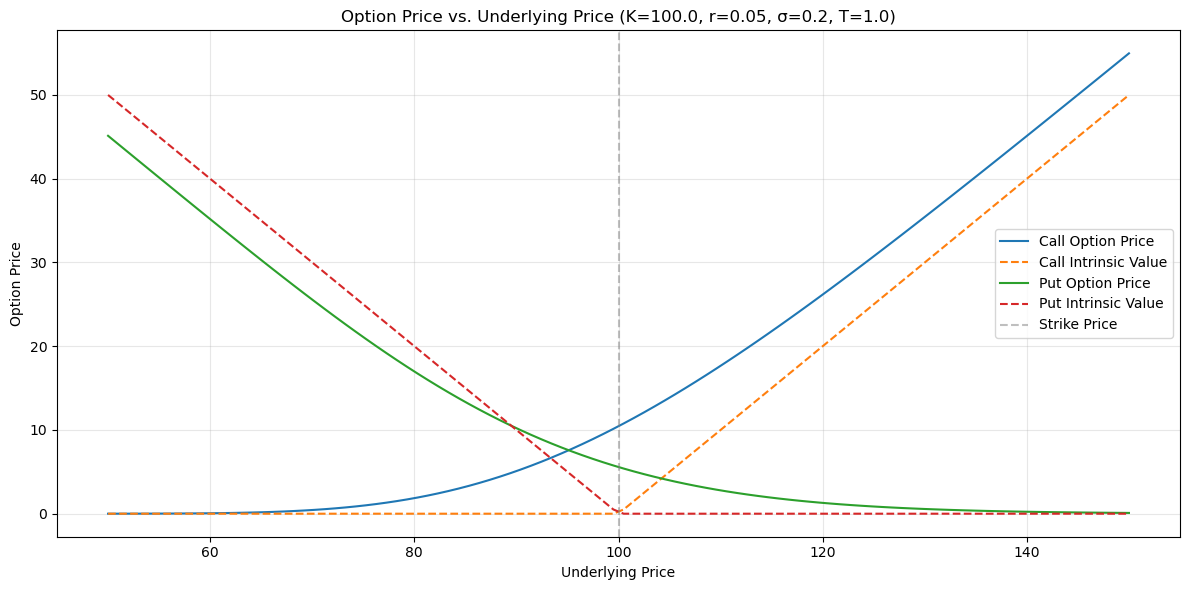

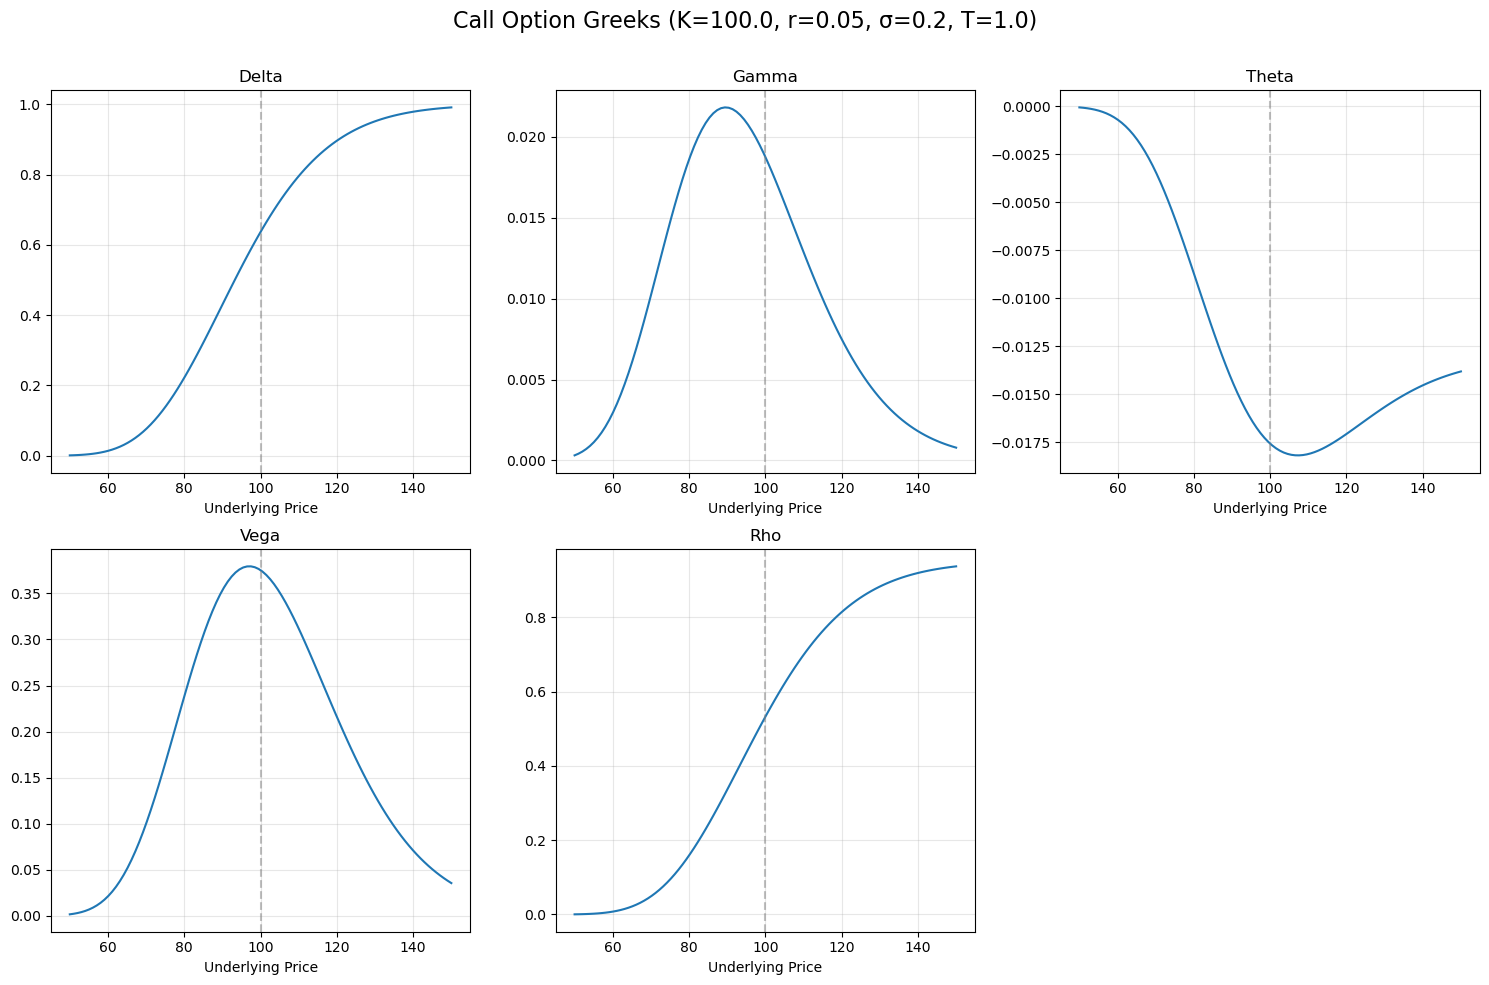

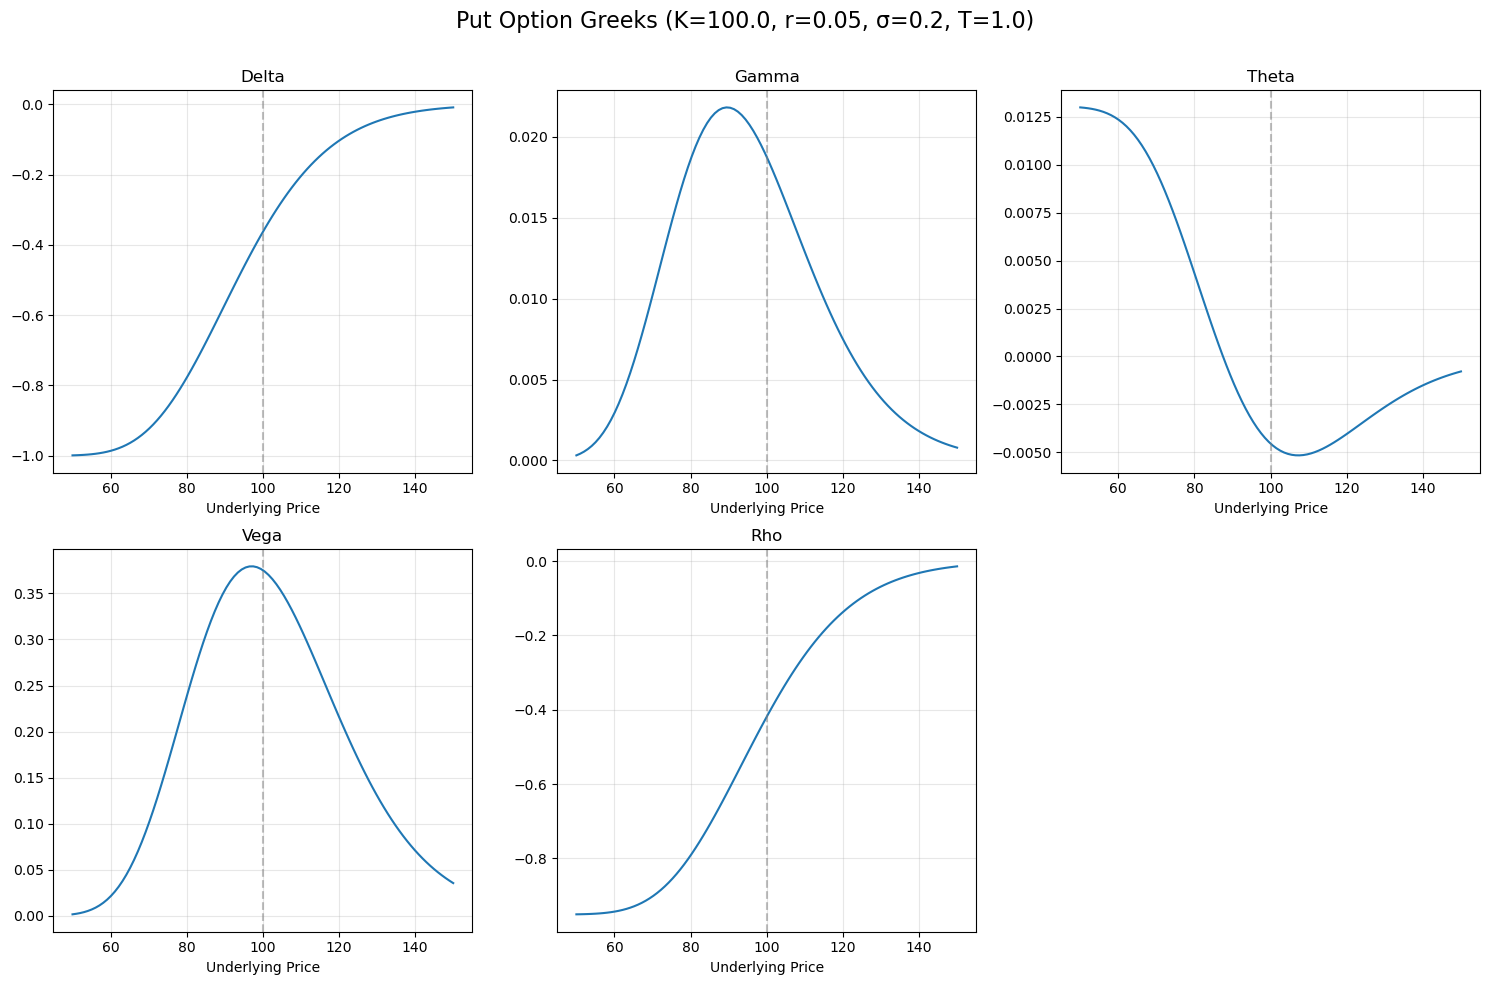

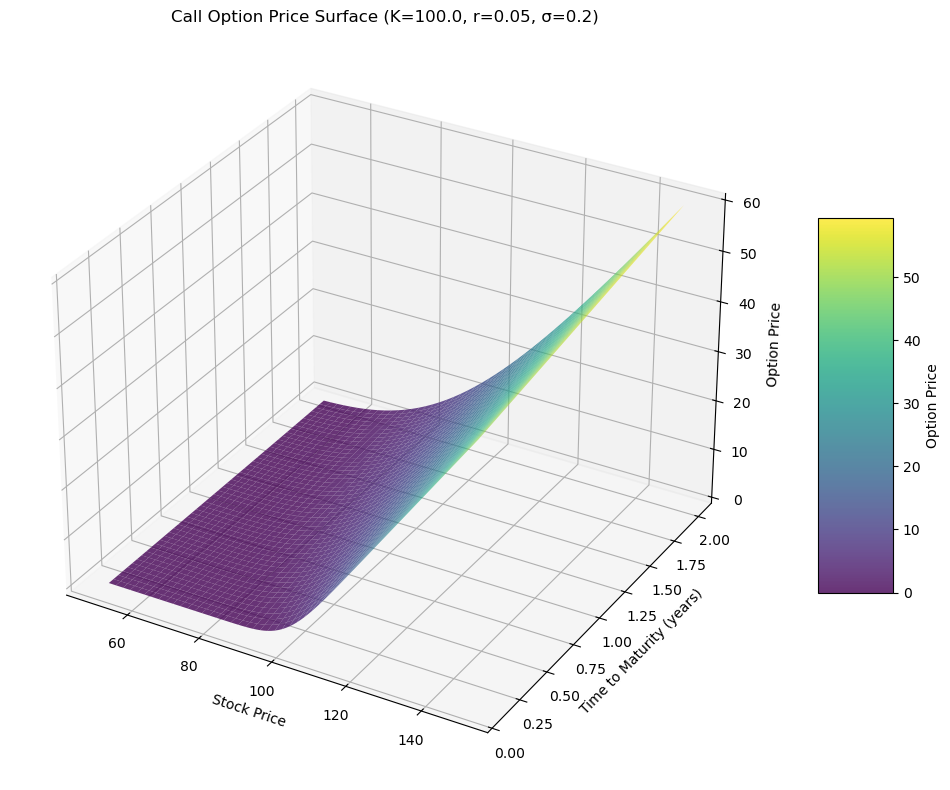

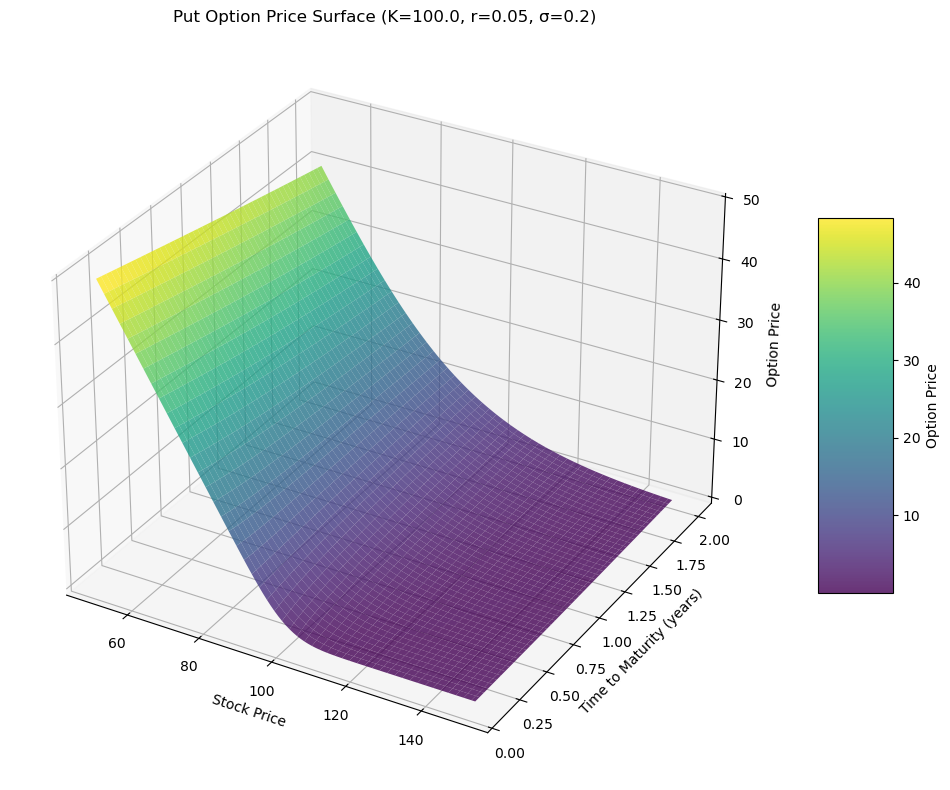

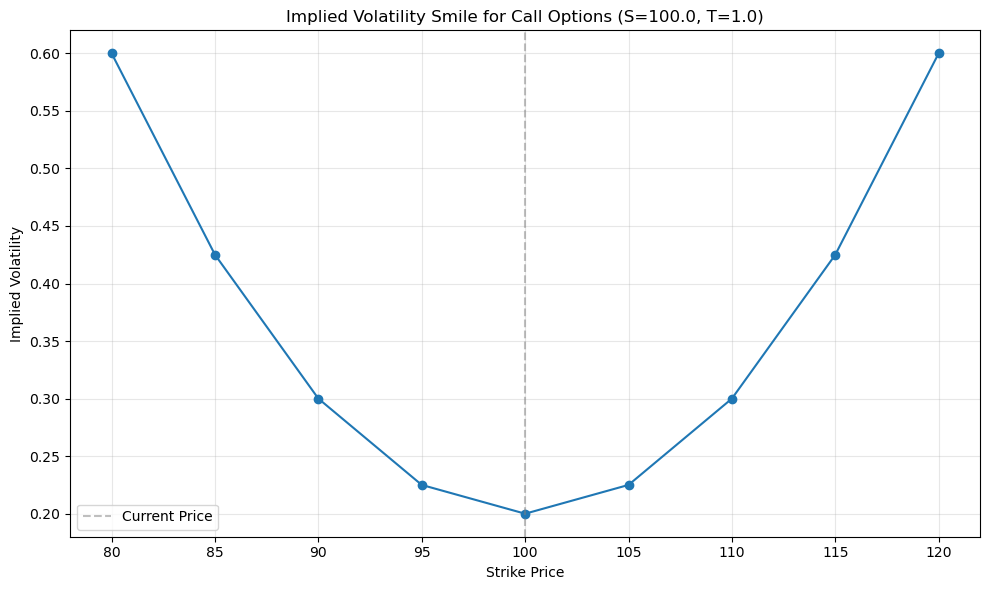

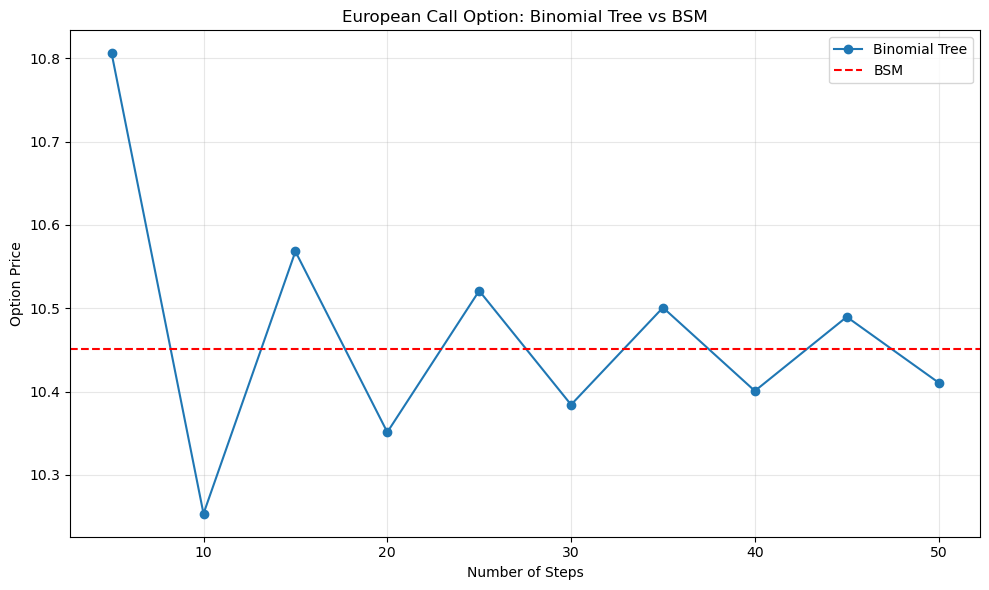

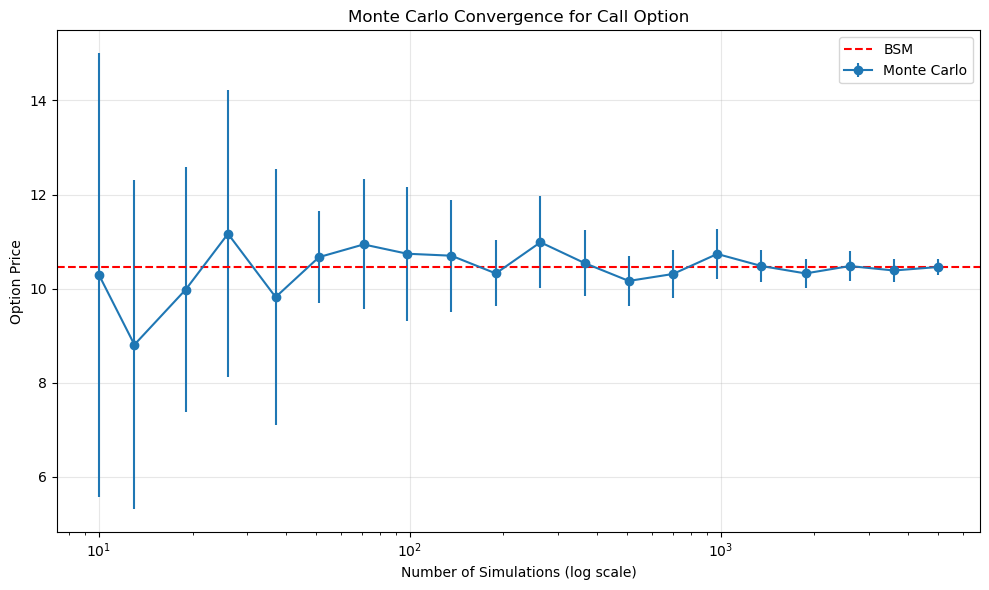

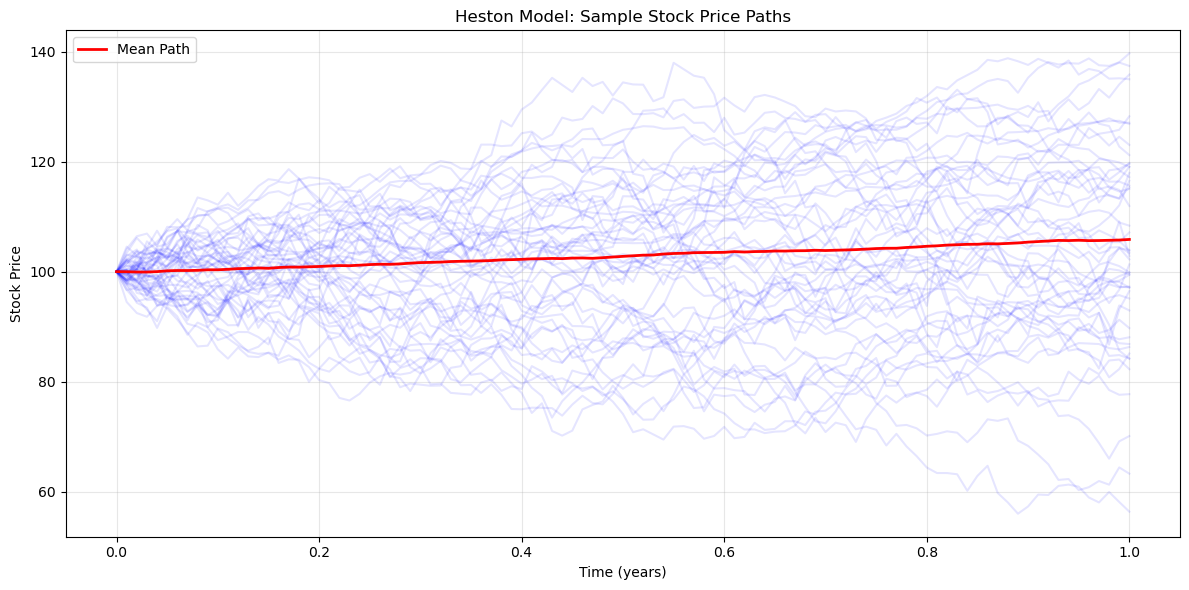

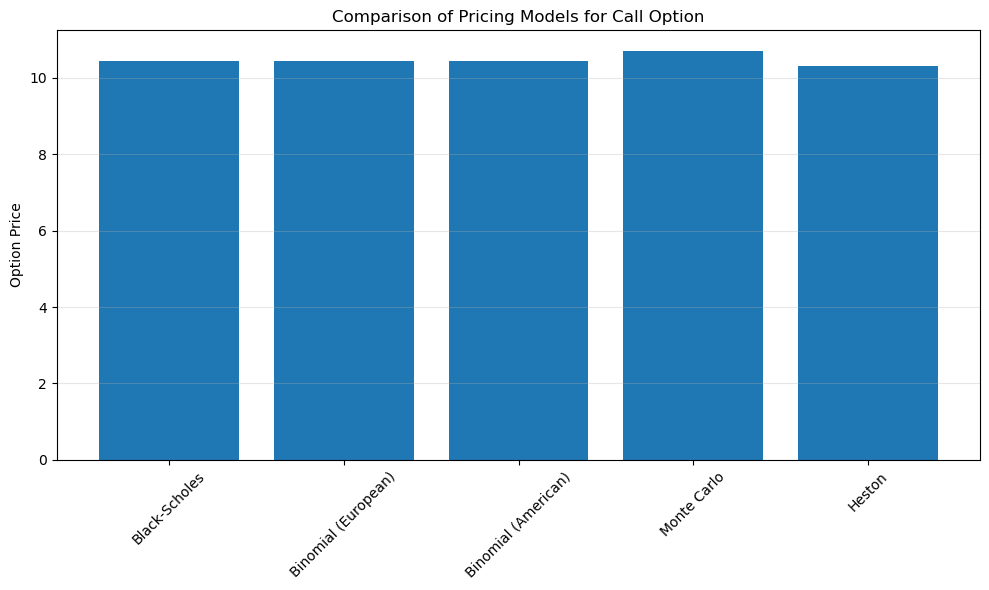


Comparison of Pricing Models:
                 Model      Price  Difference from BSM
0        Black-Scholes  10.450584             0.000000
1  Binomial (European)  10.430612            -0.019972
2  Binomial (American)  10.430612            -0.019972
3          Monte Carlo  10.709847             0.259263
4               Heston  10.303337            -0.147247

Analyzing Long Call:


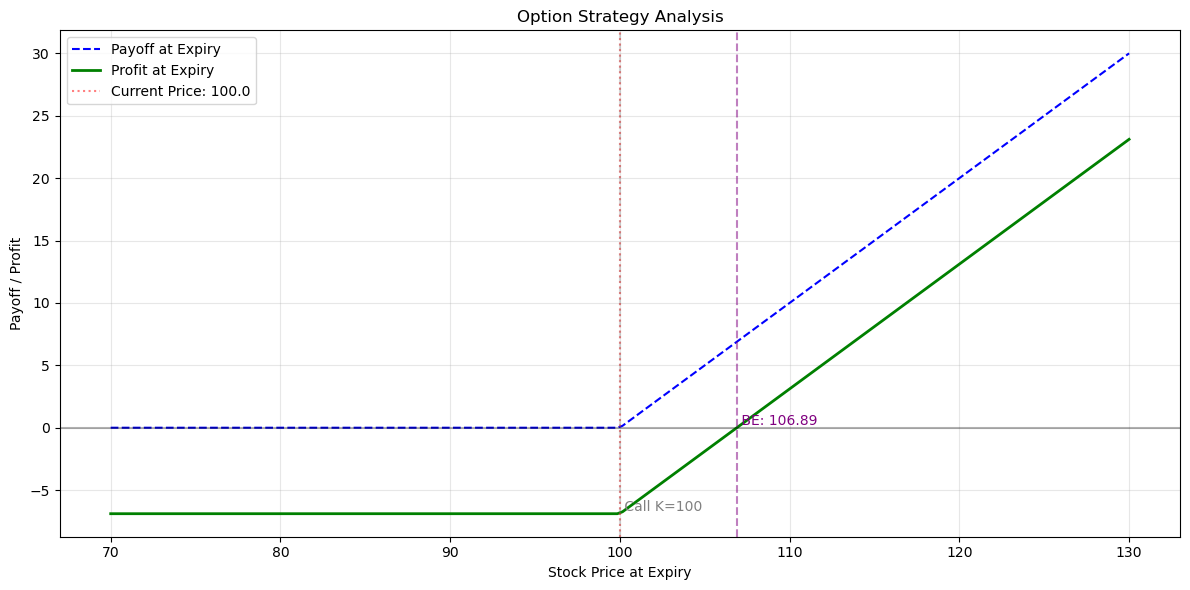

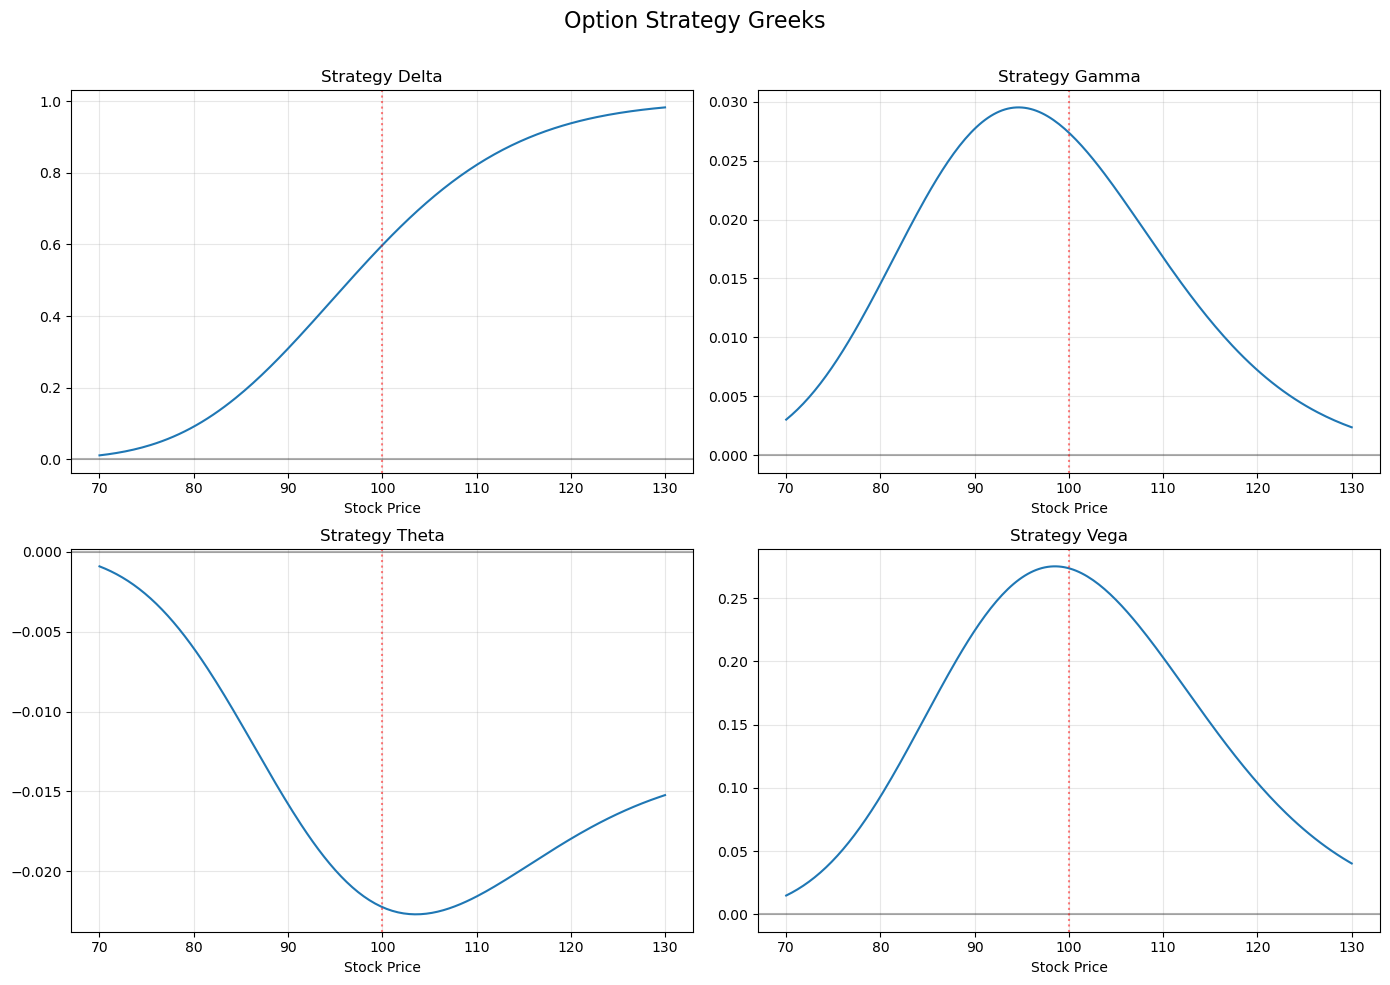

  Premium: $6.89
  Max Profit: $23.11
  Max Loss: $-6.89
  Break-even Points: ['$106.89']

Analyzing Long Put:


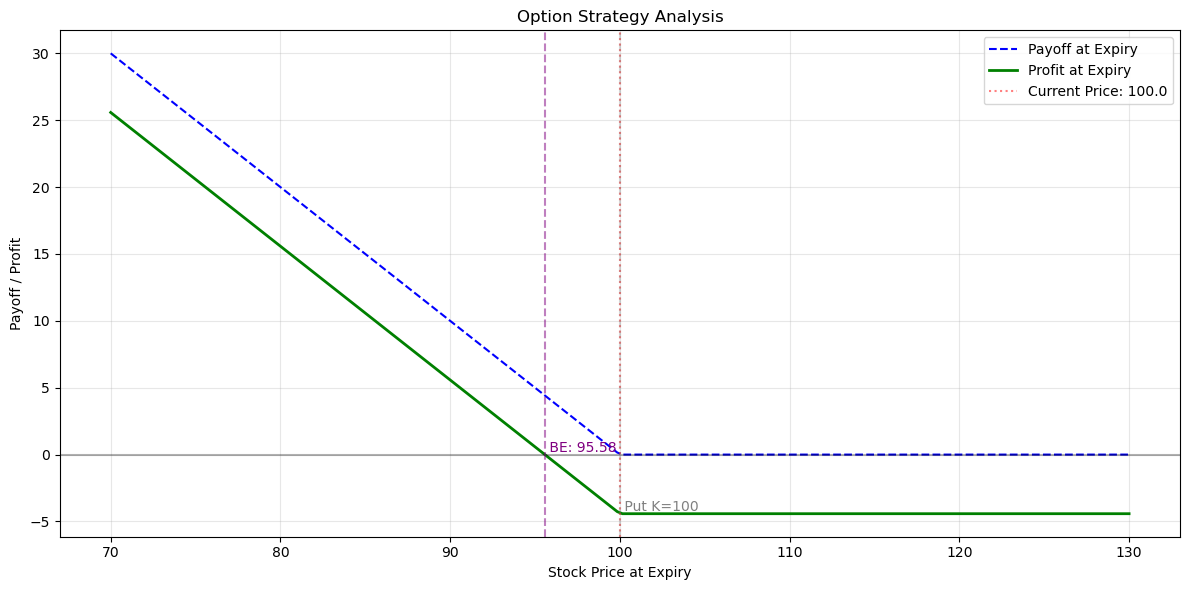

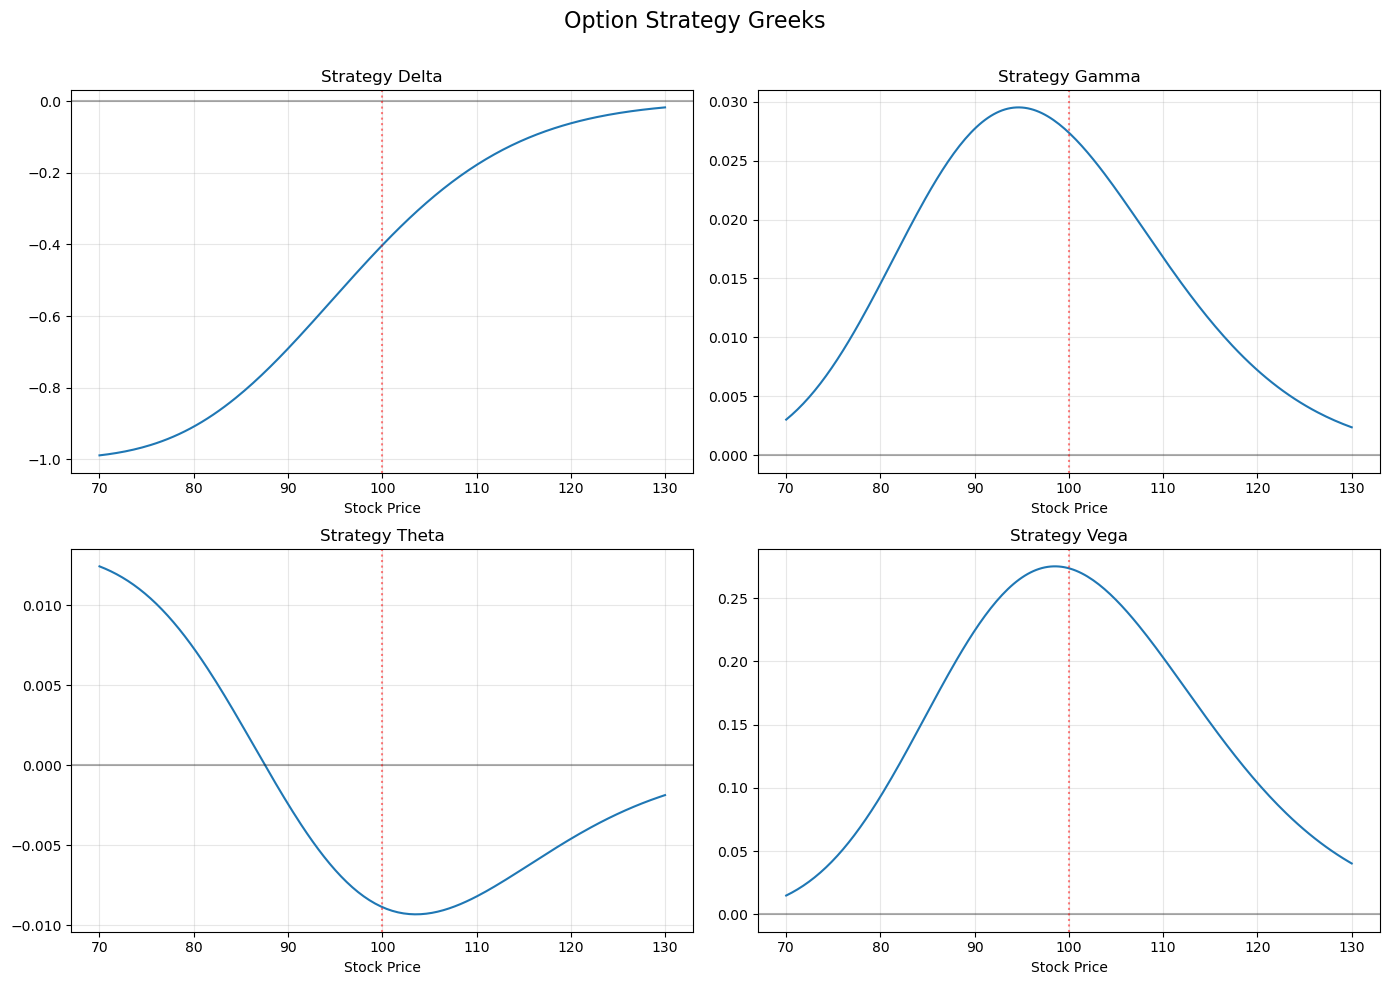

  Premium: $4.42
  Max Profit: $25.58
  Max Loss: $-4.42
  Break-even Points: ['$95.58']

Analyzing Covered Call:


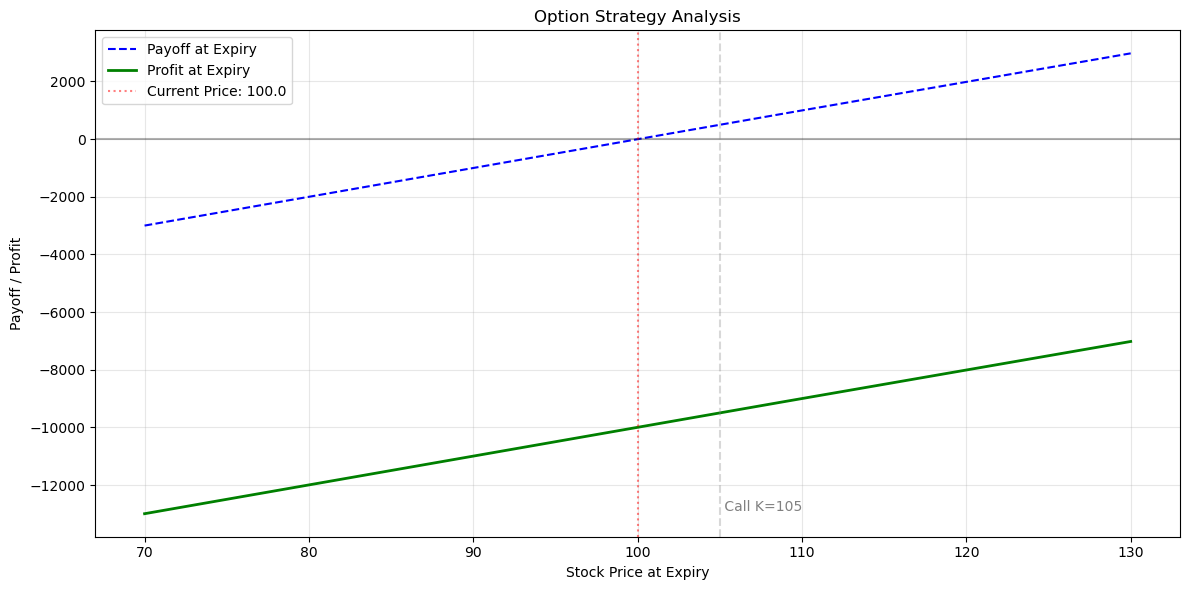

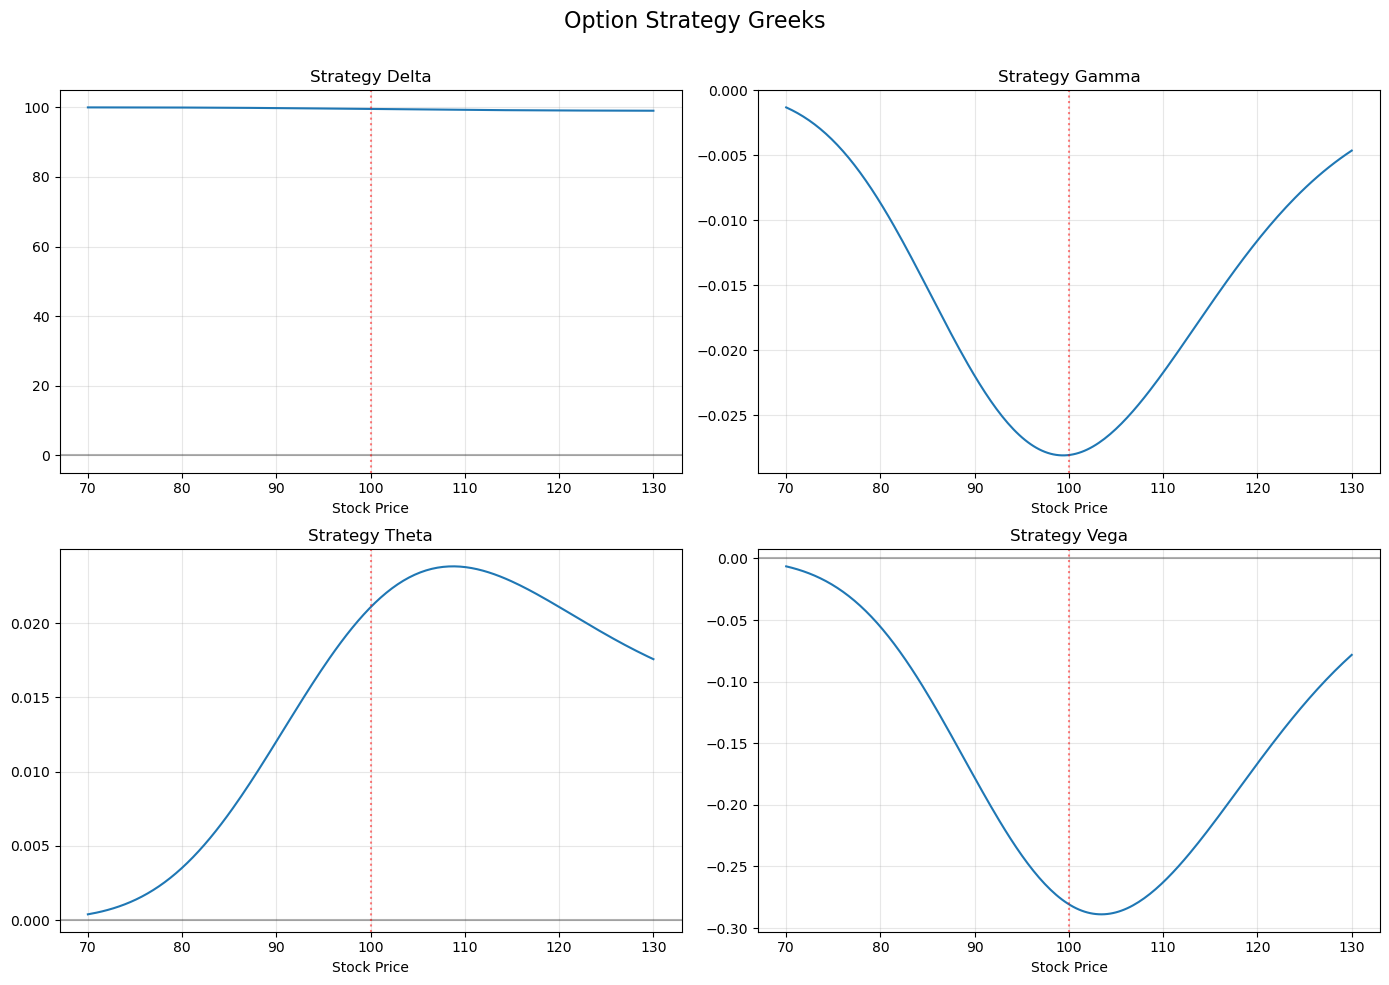

  Premium: $9995.42
  Max Profit: $-7020.42
  Max Loss: $-12995.42
  Break-even Points: []

Analyzing Protective Put:


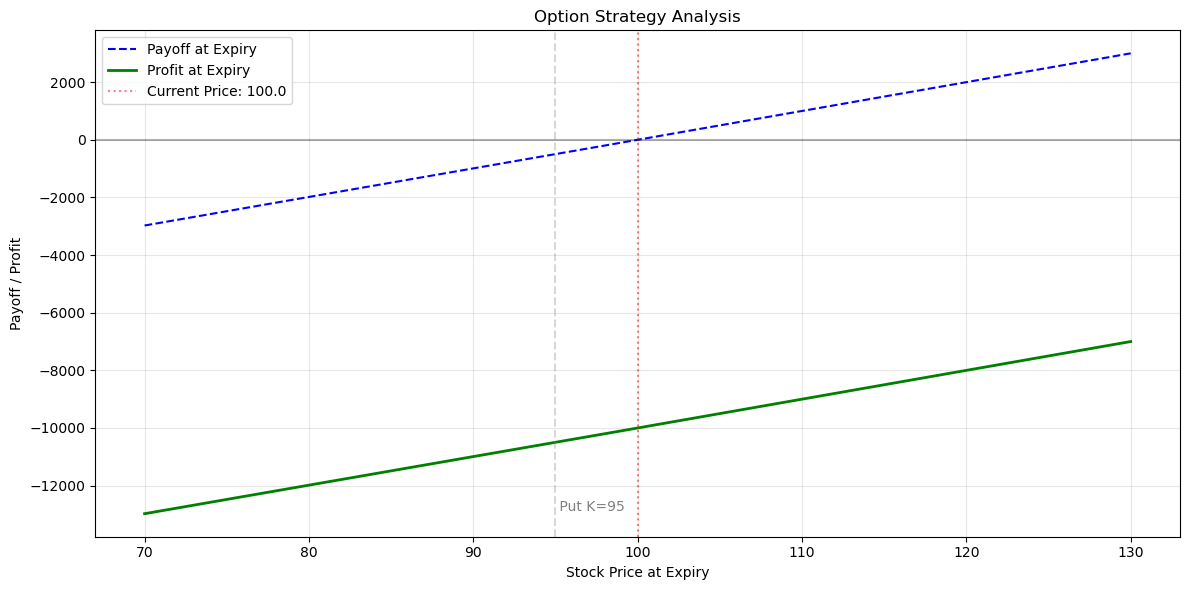

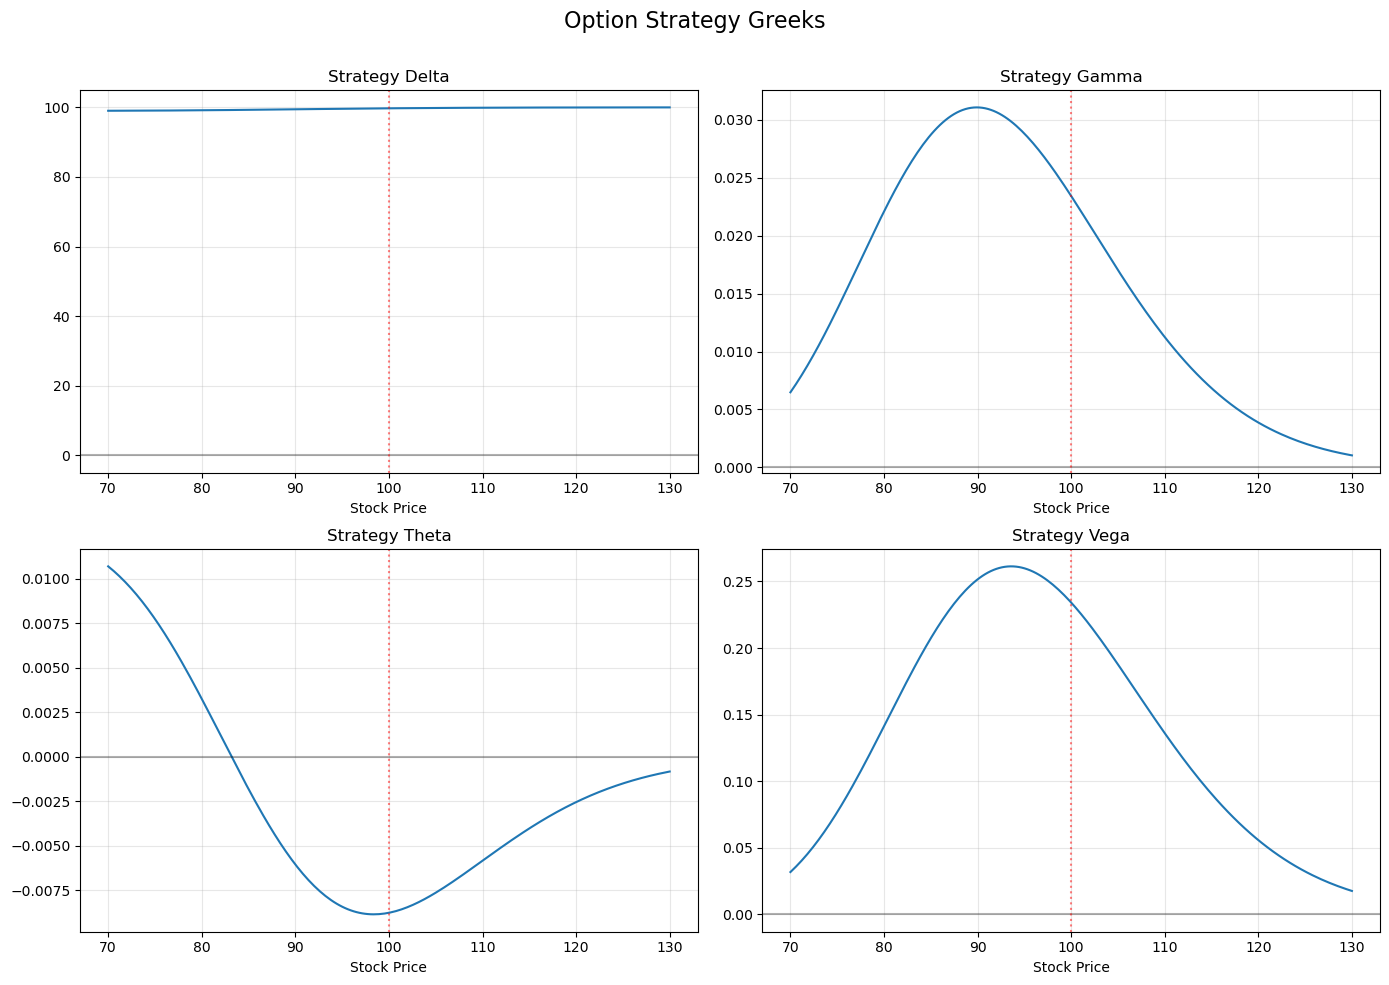

  Premium: $10002.53
  Max Profit: $-7002.53
  Max Loss: $-12977.53
  Break-even Points: []

Analyzing Bull Call Spread:


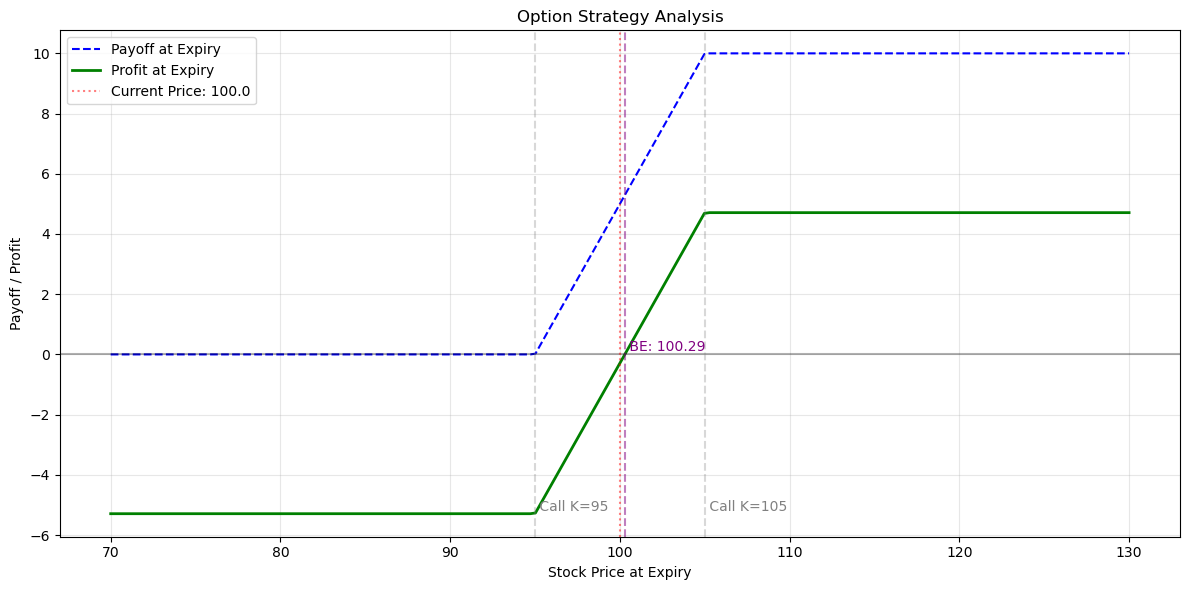

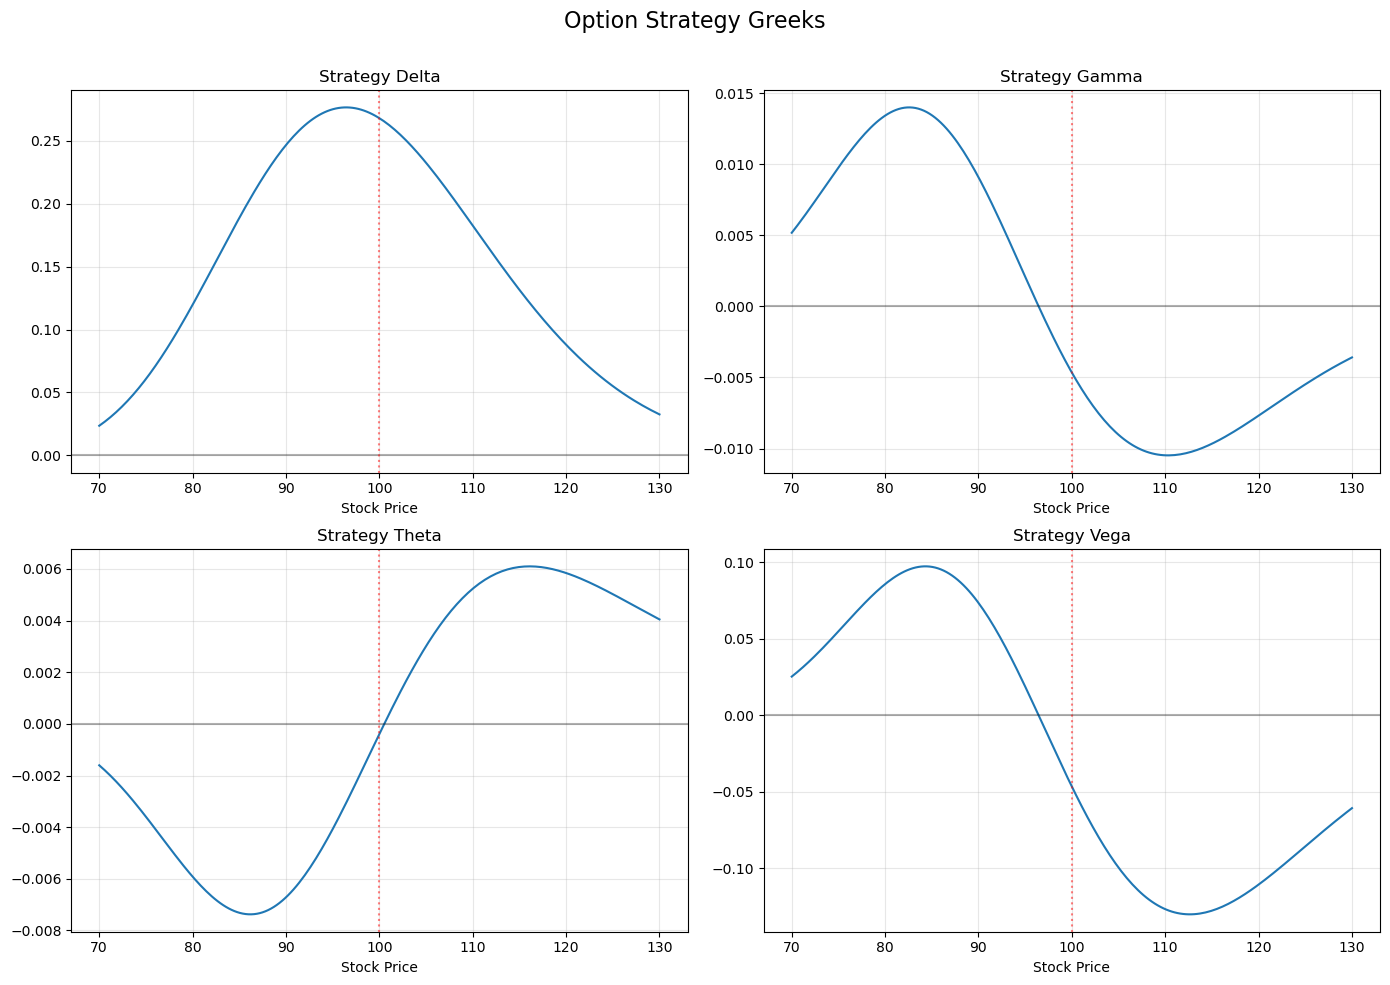

  Premium: $5.29
  Max Profit: $4.71
  Max Loss: $-5.29
  Break-even Points: ['$100.29']

Analyzing Bear Put Spread:


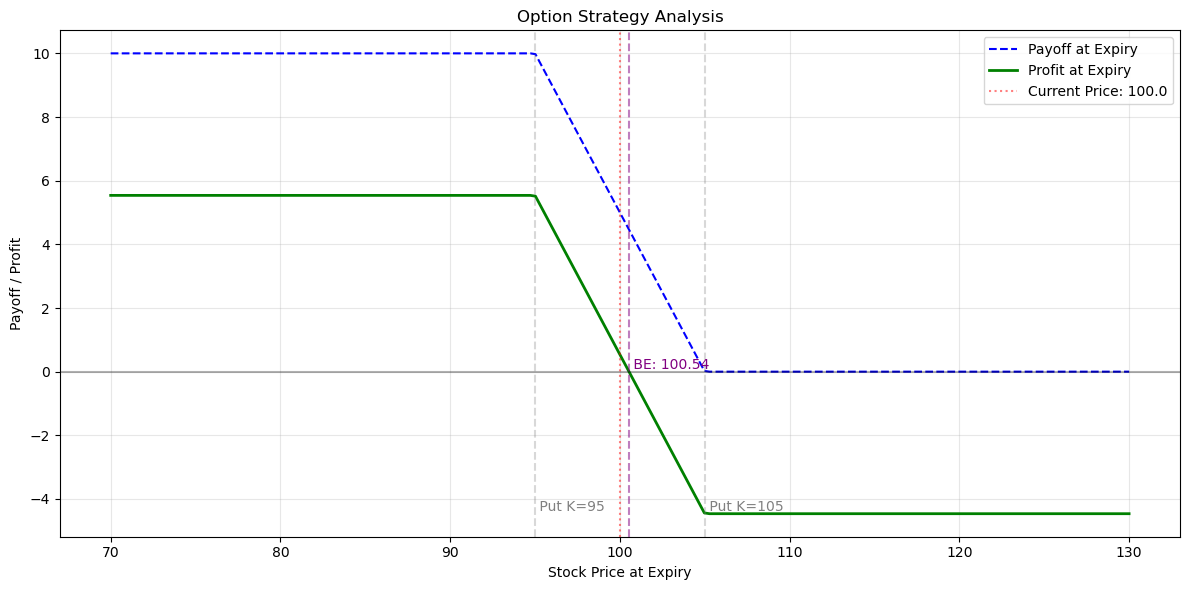

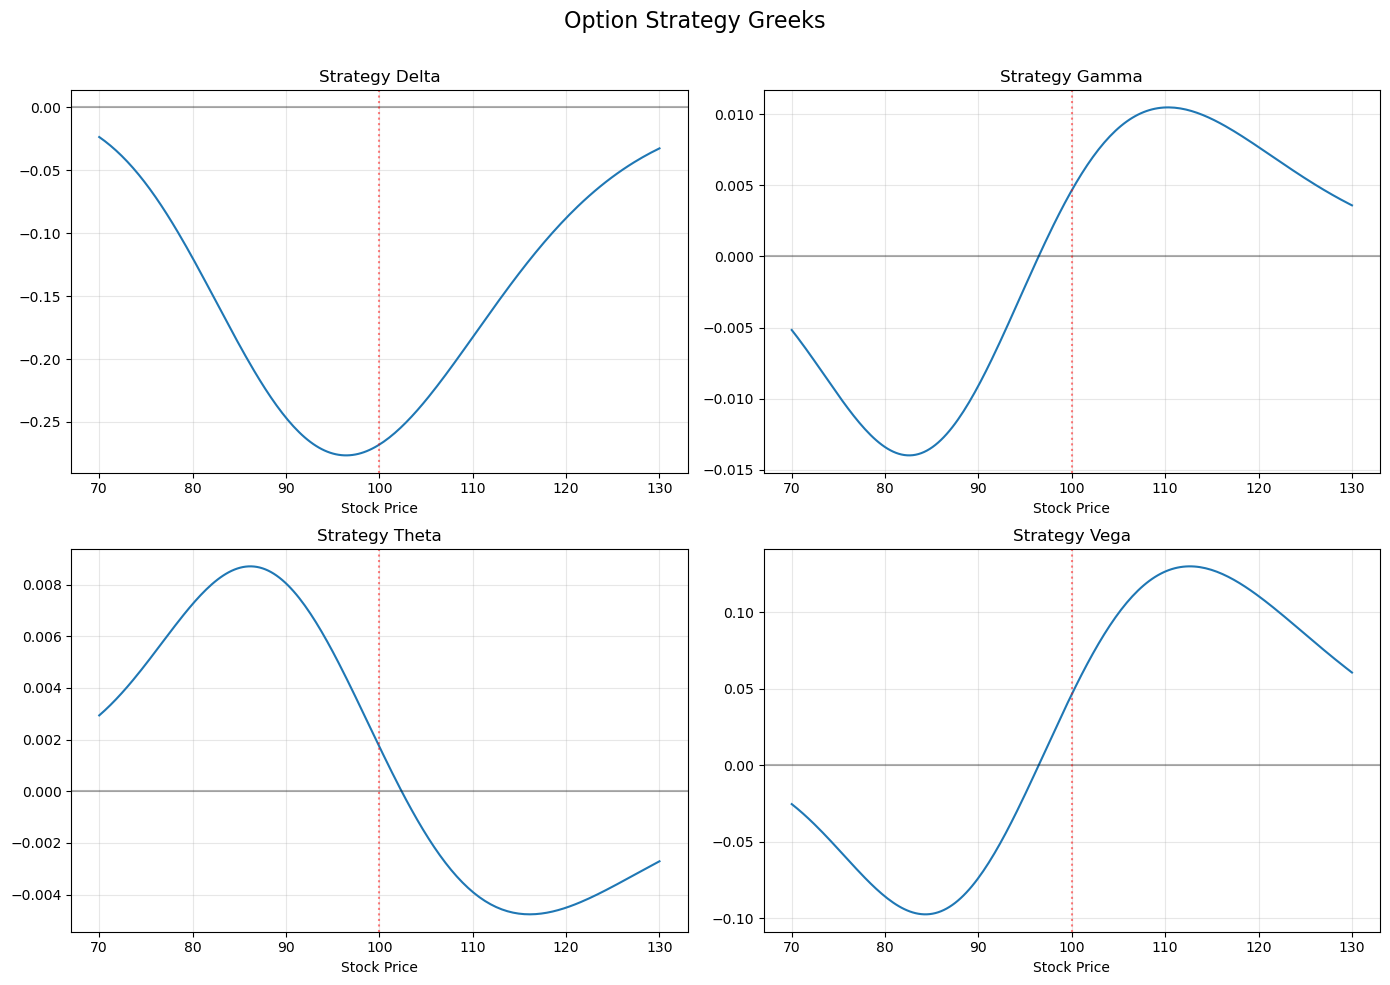

  Premium: $4.46
  Max Profit: $5.54
  Max Loss: $-4.46
  Break-even Points: ['$100.54']

Analyzing Long Straddle:


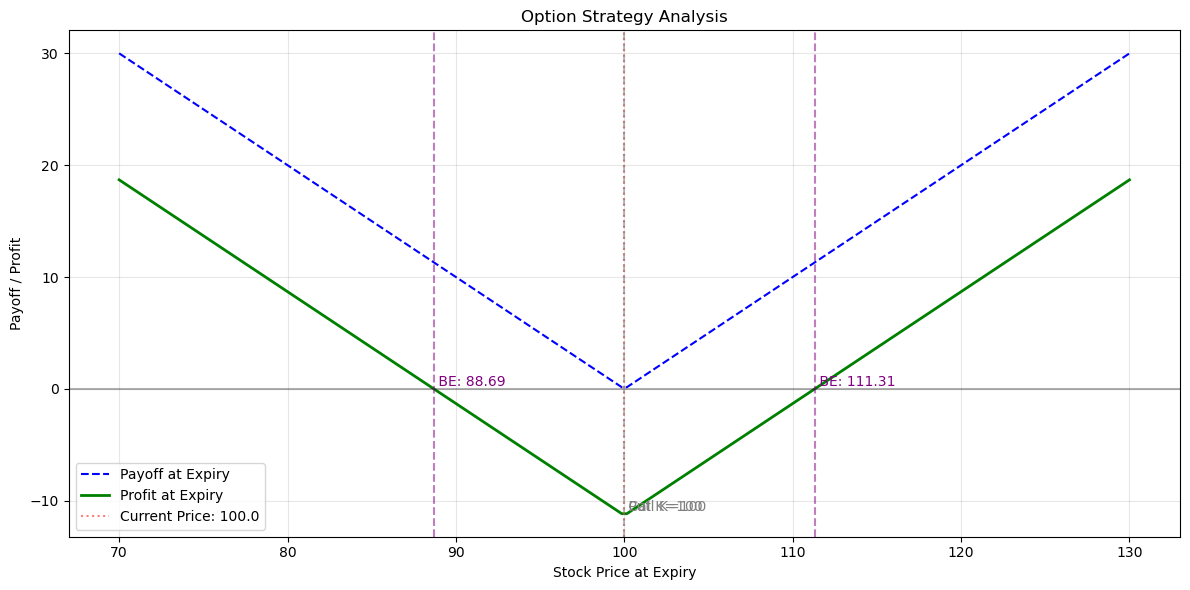

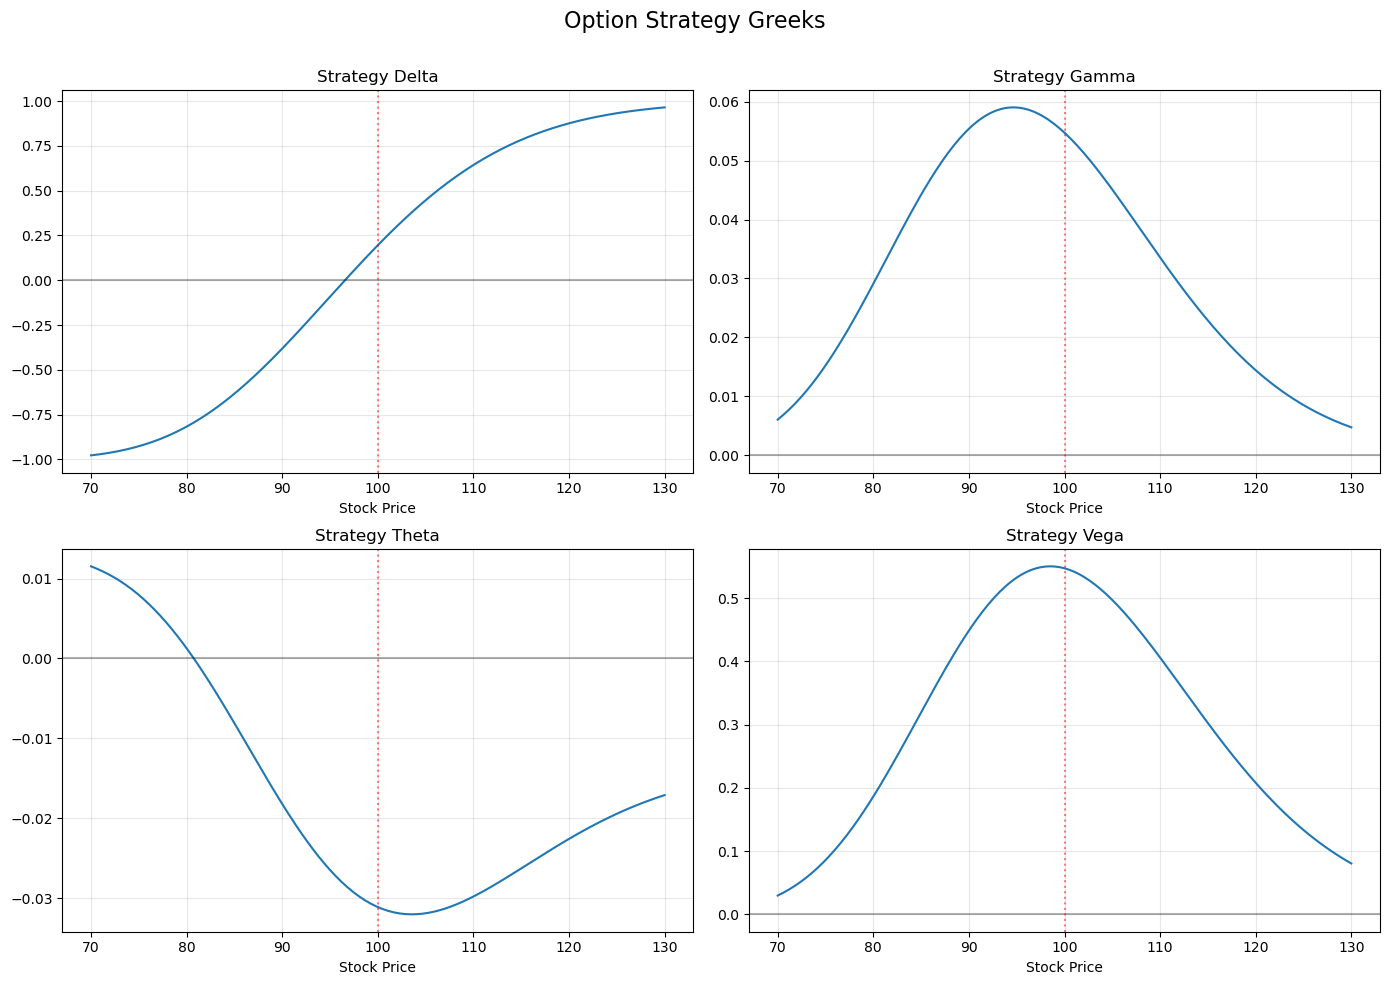

  Premium: $11.31
  Max Profit: $18.69
  Max Loss: $-11.16
  Break-even Points: ['$88.69', '$111.31']

Analyzing Long Strangle:


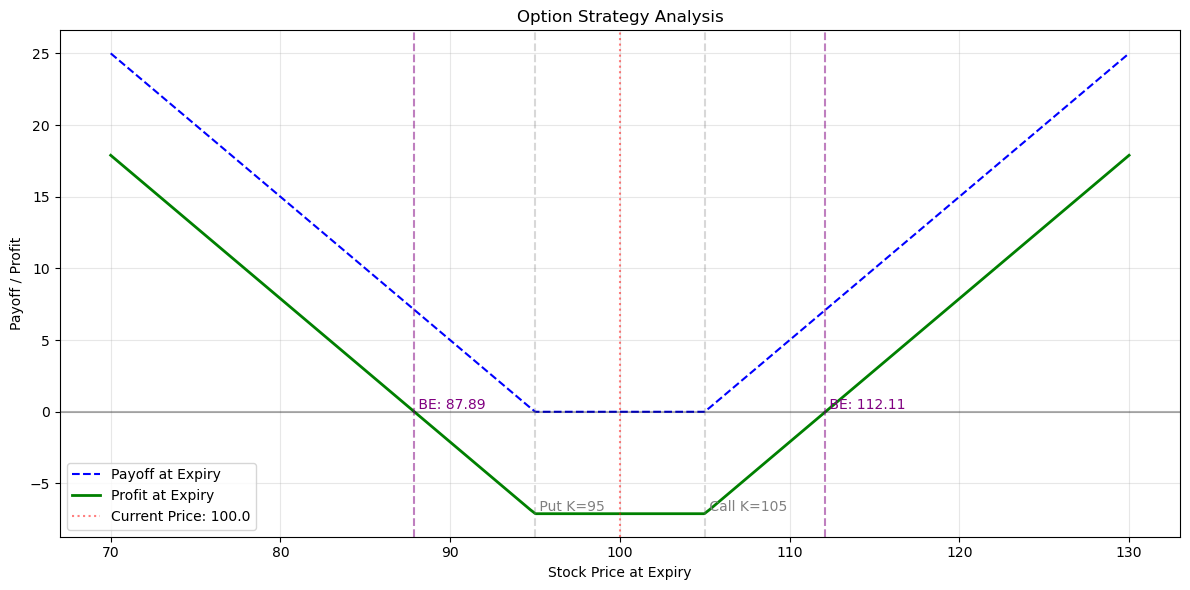

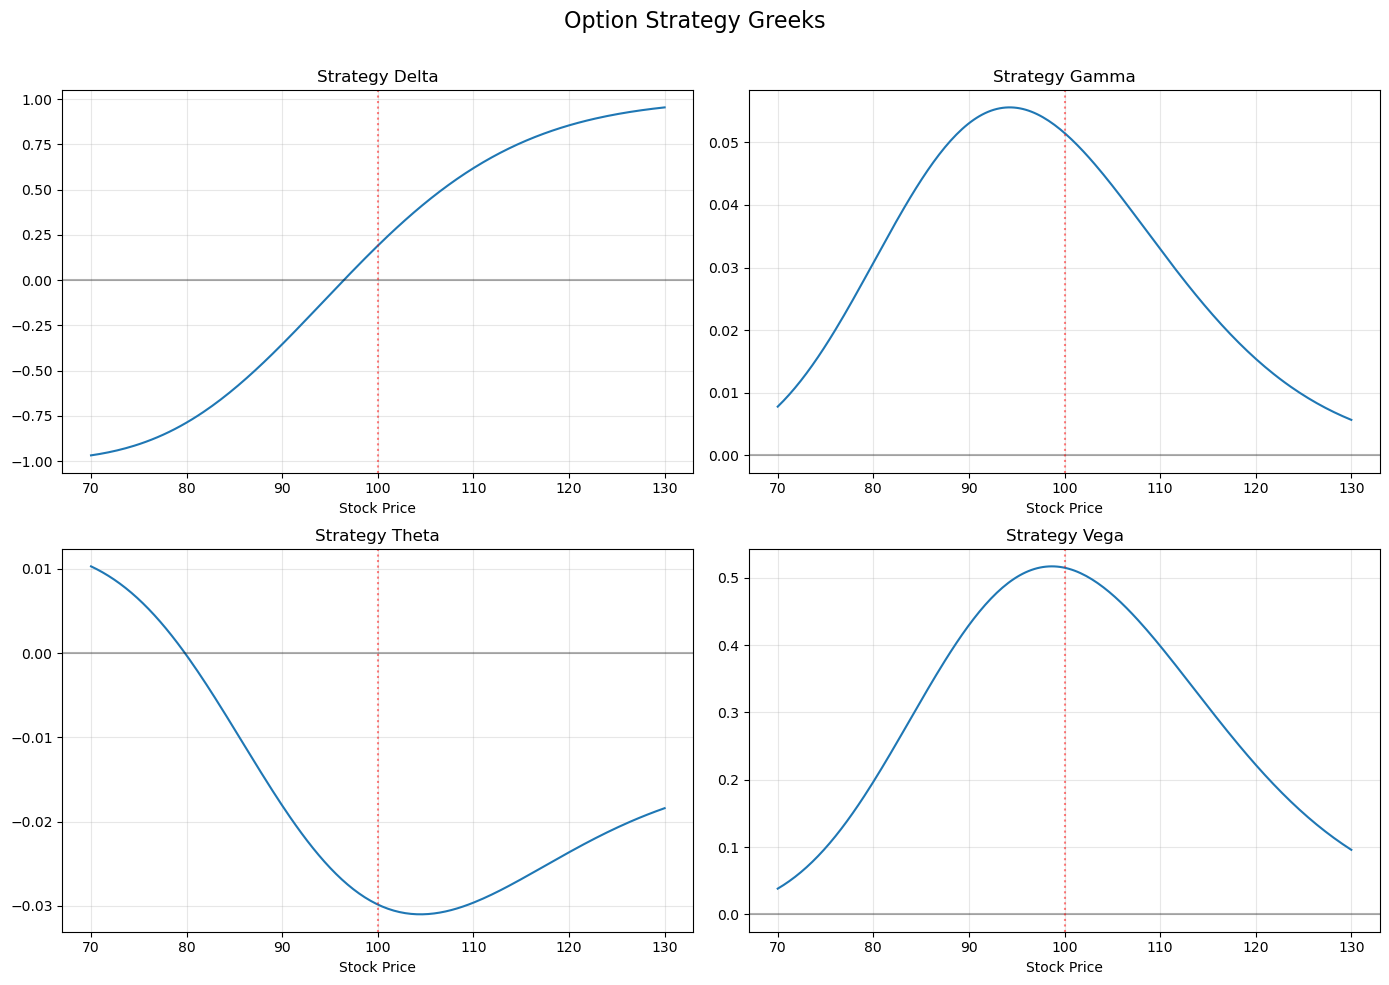

  Premium: $7.11
  Max Profit: $17.89
  Max Loss: $-7.11
  Break-even Points: ['$87.89', '$112.11']

Analyzing Butterfly Spread:


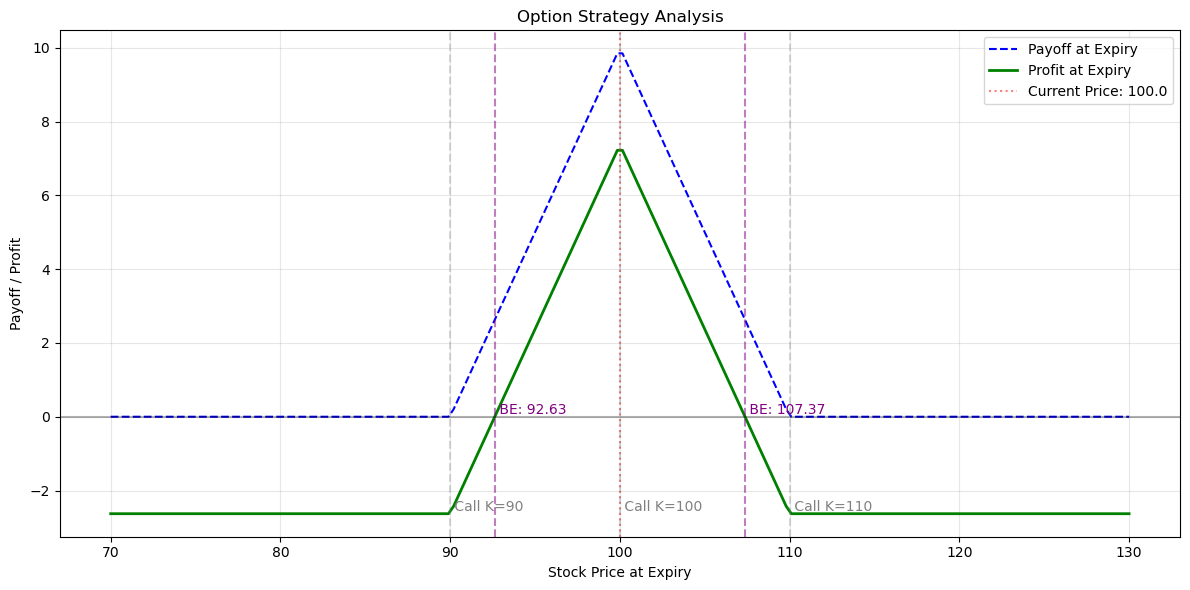

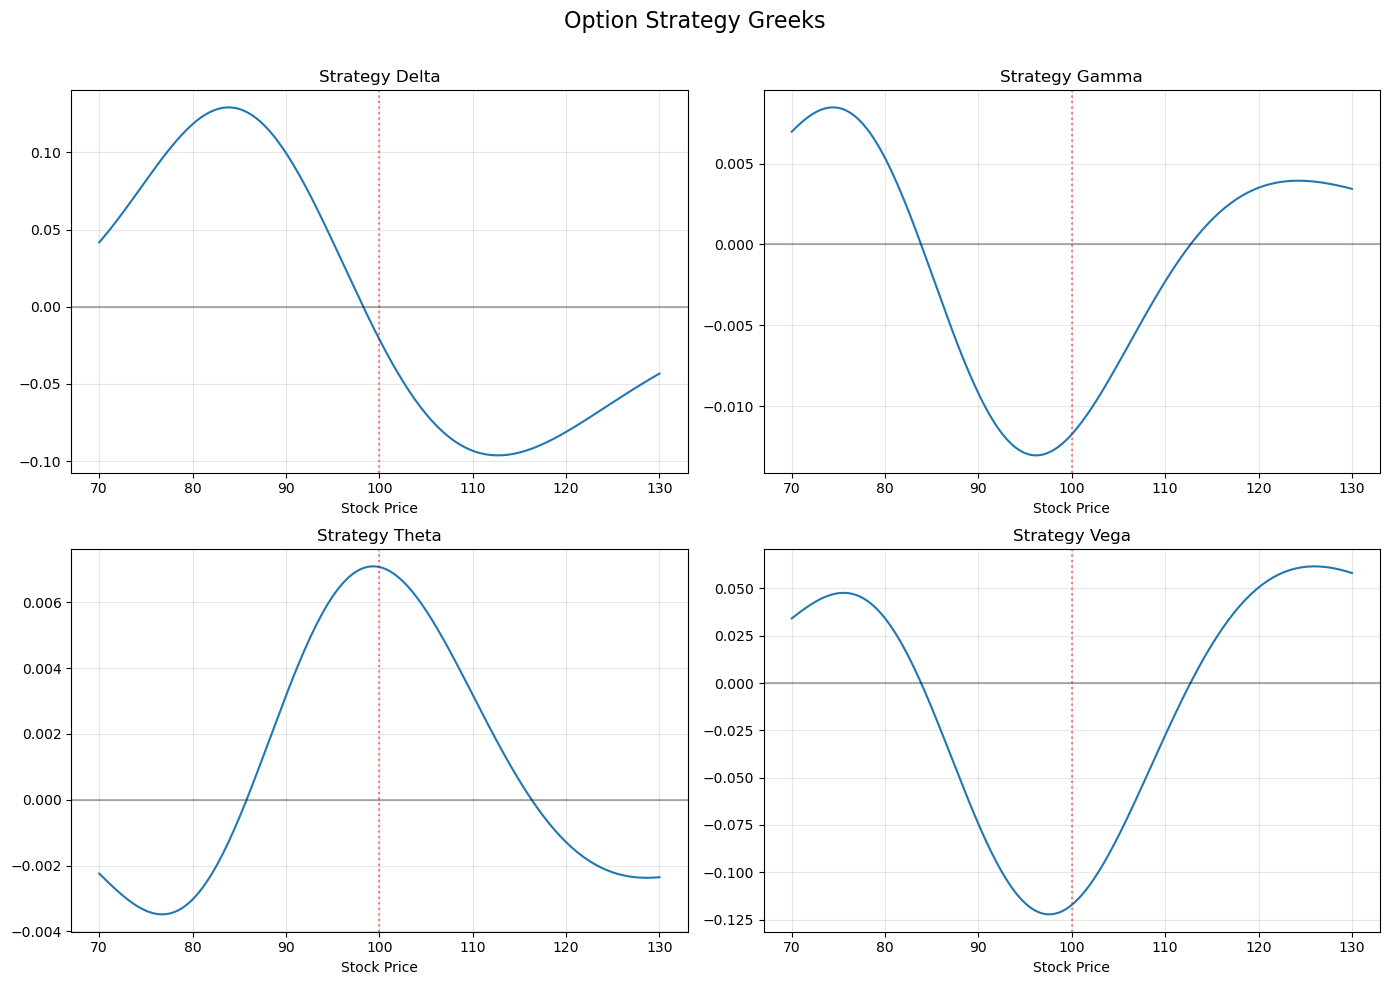

  Premium: $2.63
  Max Profit: $7.22
  Max Loss: $-2.63
  Break-even Points: ['$92.63', '$107.37']

Analyzing Iron Condor:


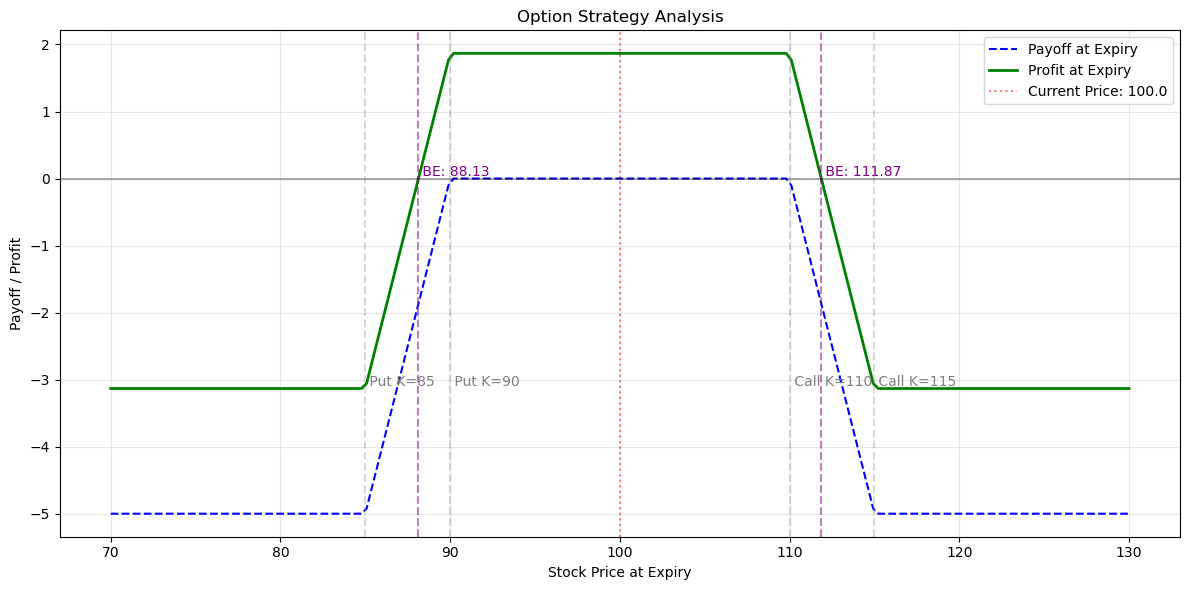

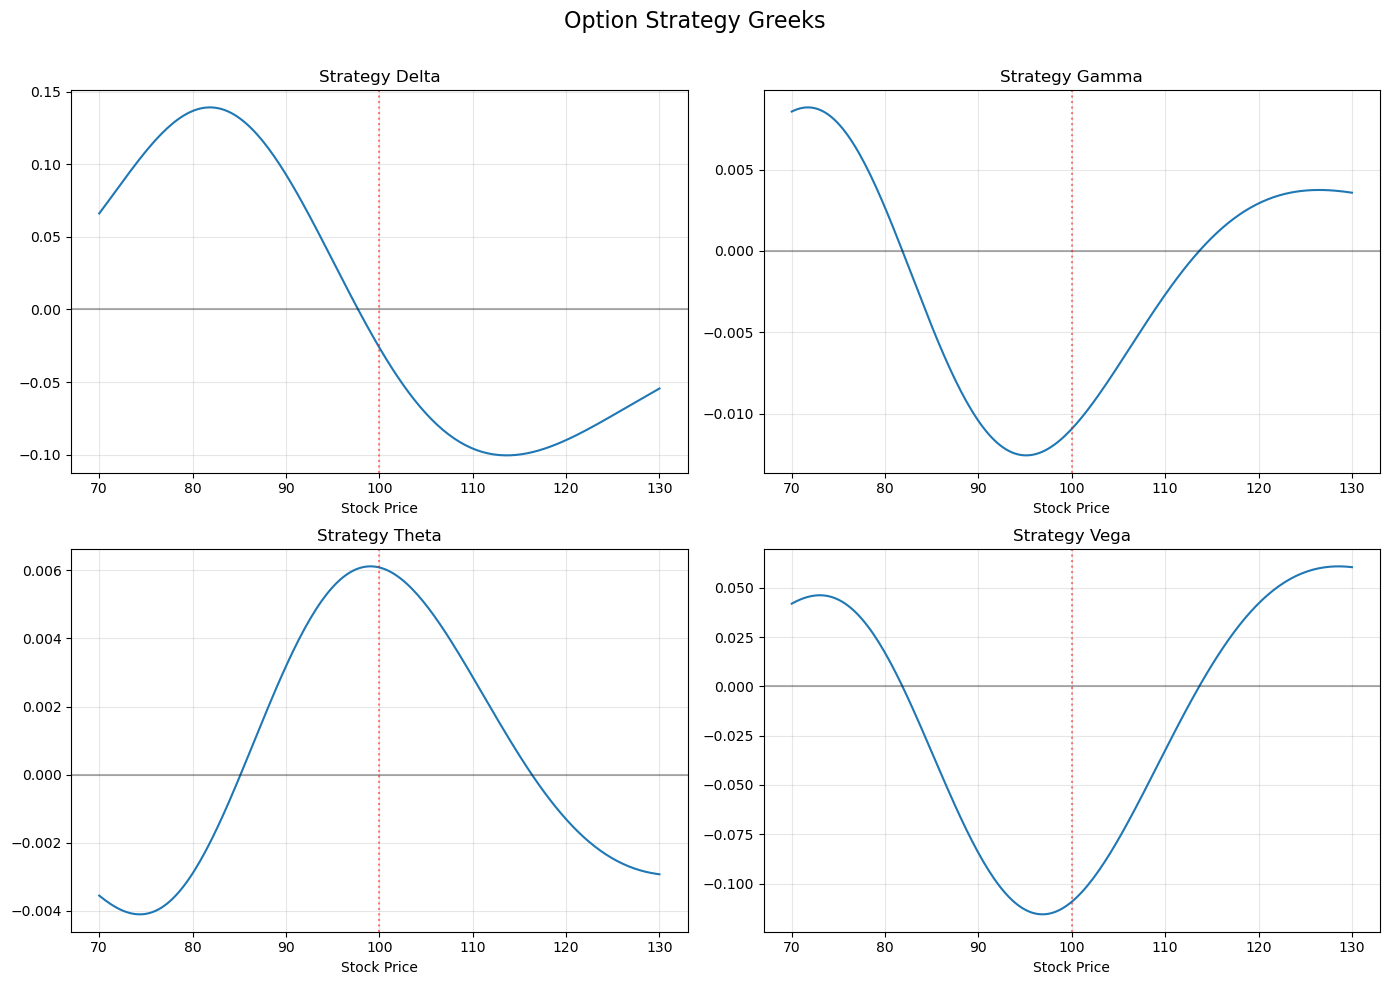

  Premium: $-1.87
  Max Profit: $1.87
  Max Loss: $-3.13
  Break-even Points: ['$88.13', '$111.87']


In [37]:
# Main function to run demonstrations
def main():
    print("Options Pricing and Strategy Analysis Tool")
    print("=========================================")
    
    # Demonstrate basic options pricing and Greeks
    demonstrate_options_pricing()
    
    # Demonstrate option strategies
    demonstrate_option_strategies()

if __name__ == "__main__":
    main()